# TriGate

# Functions

### General set up

In [1]:
from flashrag.config import Config


def set_config(dataset_name: str, split='train'):
    # Initialize a note indicating this is a zero-shot setup
    save_note = 'zero-shot'
    
    # Create a dictionary to store configuration details including the dataset name and split
    config_dict = {'save_note': save_note, 'dataset_name': dataset_name, 'split': split}

    # Create a configuration object using an external YAML file and the provided config_dict
    config = Config('carlos_config.yaml', config_dict)
    
    
    # Return the configuration object
    return config

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import os
import torch

def get_load_generator_model(config, hidden_states=True, float16=True):
    # Set the cache directory path for Hugging Face models
    cache_path = './hf_cache/'

    # Set environment variables for Hugging Face to use the cache directory
    os.environ['HF_HOME'] = cache_path
    os.environ['TRANSFORMERS_CACHE'] = cache_path

    # Extract the model name from the configuration
    name_model = config['generator_model']

    # Define the folder where the model is located
    folder_path = '/cs/student/projects2/dsml/cdiezmar/models/'
    model_path = folder_path + name_model

    # Load model configuration with or without hidden states based on the input argument
    if hidden_states:
        model_config = AutoConfig.from_pretrained(model_path, cache_dir=cache_path)
        model_config.output_hidden_states = True  # Enable output of hidden states

    # Load the model with the specified precision (float16 or default precision)
    if float16:
        model = AutoModelForCausalLM.from_pretrained(model_path, config=model_config, cache_dir=cache_path, torch_dtype=torch.float16)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_path, config=model_config, cache_dir=cache_path)

    # Load the tokenizer for the model
    tokenizer = AutoTokenizer.from_pretrained(model_path, cache_dir=cache_path)

    # Return the loaded model and tokenizer
    return model, tokenizer

/cs/student/projects2/dsml/cdiezmar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import random
def prepare_data(one_hidden_states, zero_hidden_states):
    # Create labels for time-sensitive (1) and non-time-sensitive (0) data
    one_labels = torch.ones(one_hidden_states.size(0), dtype=torch.long)  # Time-sensitive = 1
    zero_labels = torch.zeros(zero_hidden_states.size(0), dtype=torch.long)  # Non-time-sensitive = 0

    # Concatenate the time-sensitive and non-time-sensitive hidden states into one dataset
    all_data = torch.cat((one_hidden_states, zero_hidden_states), dim=0)
    
    # Concatenate the corresponding labels
    all_labels = torch.cat((one_labels, zero_labels), dim=0)

    # Create a dataset by pairing the hidden states with their corresponding labels
    dataset = list(zip(all_data, all_labels))
    
    # Shuffle the dataset to randomize the order of samples
    random.shuffle(dataset)

    # Split the dataset into training (80%) and validation (20%) sets
    split_idx = int(0.8 * len(dataset))
    train_data, val_data = dataset[:split_idx], dataset[split_idx:]

    # Unzip the inputs and labels for the training and validation datasets
    train_inputs, train_labels = zip(*train_data)
    val_inputs, val_labels = zip(*val_data)

    # Convert the training and validation inputs into tensors
    train_inputs = torch.stack(train_inputs)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    val_inputs = torch.stack(val_inputs)
    val_labels = torch.tensor(val_labels, dtype=torch.long)

    # Return the prepared training and validation inputs and labels
    return train_inputs, train_labels, val_inputs, val_labels

def prepare_data_intent(new_hidden_states):
    # Assume half of the dataset is intent-aware (1) and the other half is not (0)
    half_size = new_hidden_states.size(0) // 2

    # Split the dataset into two halves: one for intent-aware (1) and the other for non-intent-aware (0)
    one_hidden_states = new_hidden_states[:half_size]  # Intent-aware
    zero_hidden_states = new_hidden_states[half_size:]  # Non-intent-aware

    # Create labels: 1 for intent-aware, 0 for non-intent-aware
    one_labels = torch.ones(one_hidden_states.size(0), dtype=torch.long)  # Intent-aware = 1
    zero_labels = torch.zeros(zero_hidden_states.size(0), dtype=torch.long)  # Non-intent-aware = 0

    # Concatenate the hidden states and corresponding labels to form the complete dataset
    all_data = torch.cat((one_hidden_states, zero_hidden_states), dim=0)
    all_labels = torch.cat((one_labels, zero_labels), dim=0)

    # Pair the data and labels, and shuffle the dataset
    dataset = list(zip(all_data, all_labels))
    random.shuffle(dataset)

    # Split the dataset into training (80%) and validation (20%) sets
    split_idx = int(0.8 * len(dataset))
    train_data, val_data = dataset[:split_idx], dataset[split_idx:]

    # Unzip the training and validation data to separate inputs and labels
    train_inputs, train_labels = zip(*train_data)
    val_inputs, val_labels = zip(*val_data)

    # Convert the inputs and labels into PyTorch tensors
    train_inputs = torch.stack(train_inputs)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    val_inputs = torch.stack(val_inputs)
    val_labels = torch.tensor(val_labels, dtype=torch.long)

    # Return the prepared training and validation data
    return train_inputs, train_labels, val_inputs, val_labels


In [4]:
import torch
from tqdm import tqdm

### GPU

def extract_hidden_states(config, template, batch_size=6, device='cpu'):
    # Prepare the dataset and load the model and tokenizer
    all_split = get_dataset(config)  # Retrieve the dataset based on the provided config
    split = config['split'][0]  # Use the specified dataset split (e.g., train, test)
    dataset = all_split[split]  # Access the split dataset (e.g., questions in this case)
    
    # Load the generator model with hidden state outputs and float16 precision
    model, tokenizer = get_load_generator_model(config=config, hidden_states=True, float16=True)
    
    # Set pad token if it is not already set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Move model to the specified device (CPU or GPU)
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    hidden_states_list = []  # Initialize a list to store hidden states

    # Process the dataset in batches
    for i in tqdm(range(0, len(dataset.question), batch_size)):
        # Get a batch of questions
        batch_questions = dataset.question[i:i+batch_size]
        
        # Use the template to create input prompts based on the questions
        input_prompts = [template.get_string(question=q) for q in batch_questions]
        
        # Tokenize the input prompts, returning them as tensors with padding and truncation
        inputs = tokenizer(input_prompts, return_tensors='pt', padding=True, truncation=True)
        
        # Move the inputs to the specified device (CPU or GPU)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Disable gradient calculations as we're in evaluation mode
        with torch.no_grad():
            # Forward pass through the model to get outputs including hidden states
            outputs = model(**inputs)
        
        # Extract the last hidden state of the last token in each sequence and move to CPU
        batch_hidden_states = outputs.hidden_states[-1][:, -1, :].cpu().numpy()
        
        # Add the extracted hidden states to the list
        hidden_states_list.extend(batch_hidden_states)

    # Return the complete list of hidden states
    return hidden_states_list

In [5]:
from flashrag.utils import get_dataset
def load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa):
    # Extract hidden states from TAQA dataset using the provided config and template
    taqa_hidden_states = extract_hidden_states(config=config_taqa, template=template_taqa)
    
    # Extract hidden states from TriviaQA dataset using the provided config and template
    triviaqa_hidden_states = extract_hidden_states(config=config_triviaqa, template=template_triviaqa)
    
    # Return the hidden states for both datasets
    return taqa_hidden_states, triviaqa_hidden_states

### Pipelines - ZeroShot SKR VanillaFilter

In [6]:
from flashrag.config import Config
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset

def zero_shot(dataset_name: str, split: str):
    # Set the save note to indicate a zero-shot task
    save_note = 'zero-shot'

    # Create a configuration dictionary with the dataset name and split (train, test, etc.)
    config_dict = {'save_note': save_note, 'dataset_name': dataset_name, 'split': split}

    # Load the configuration using a YAML file and the provided config_dict
    config = Config('carlos_config.yaml', config_dict)

    # Retrieve the dataset using the configuration and extract the specific split (e.g., test data)
    all_split = get_dataset(config)
    test_data = all_split[split]

    # Import the PromptTemplate to create a question-answer prompt structure
    from flashrag.prompt import PromptTemplate
    
    # Set up a system prompt and user prompt for zero-shot question answering
    template = PromptTemplate(
        config=config,
        system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt="Question: {question}"
    )

    # Set up the pipeline for running the zero-shot inference
    pipeline = SequentialPipeline(config, template)

    # Run the pipeline on the test data, performing evaluation (`do_eval=True`)
    result = pipeline.naive_run(test_data, do_eval=True)

    # Return the result, configuration, and template
    return result, config, template

In [7]:
from flashrag.judger import SKRJudger
from flashrag.config import Config
from flashrag.utils import get_dataset
import numpy as np


def skr_judger_fun(dataset):
    # Set up the configuration for the SKR Judger model
    judger_name = 'skr'  # Name of the judger
    model_path = '/cs/student/projects2/dsml/cdiezmar/models/skr_embeddings'  # Path to the SKR model embeddings
    training_data_path = '/cs/student/projects2/dsml/cdiezmar/dataset/skr_dataset/skr_training.json'  # Path to the SKR training data
    dataset_name = dataset  # Name of the dataset being processed
    split = 'train'  # Specify the split (train, test, etc.)

    # Create a configuration dictionary for the SKR judger
    config_dict = {
        'judger_name': judger_name,
        'judger_model_path': model_path,
        'judger_training_data_path': training_data_path,
        'judger_topk': 3,  # Number of top results to consider
        'save_note': 'skr',  # Note to indicate this is related to SKR
        'dataset_name': dataset_name,  # Dataset name from the input argument
        'split': split  # Data split (train/test)
    }

    # Load the configuration from a YAML file using the configuration dictionary
    config = Config('carlos_config.yaml', config_dict)

    # Retrieve the dataset based on the configuration and extract the specified split (train)
    all_split = get_dataset(config)
    test_data = all_split[split]

    # Initialize the SKRJudger with the loaded configuration
    skr = SKRJudger(config)

    # Perform the judgment task on the test data using the SKRJudger
    inverted_result = skr.judge(test_data)

    # Invert the result (flip True/False) to return the expected outcome
    result = [not item for item in inverted_result]

    # Return the processed results
    return result

In [8]:
from flashrag.config import Config
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
import numpy as np

def vanillaprompt_filter(dataset_name: str, split: str):
    # Set the save note to indicate a zero-shot task
    save_note = 'zero-shot'

    # Create a configuration dictionary with the dataset name and split
    config_dict = {'save_note': save_note, 'dataset_name': dataset_name, 'split': split}

    # Load the configuration using a YAML file and the provided config_dict
    config = Config('carlos_config.yaml', config_dict)

    # Retrieve the dataset using the configuration and extract the specified split (e.g., test data)
    all_split = get_dataset(config)
    test_data = all_split[split]

    # Import the PromptTemplate to create a prompt structure for the filter
    from flashrag.prompt import PromptTemplate
    
    # Set up a prompt template that asks if the question requires retrieving an answer
    template = PromptTemplate(
        config=config,
        system_prompt="Given a question, determine whether you need to retrieve the answer. Answer [Yes] or [No]",
        user_prompt="Question: {question}"
    )

    # Define a function that processes the model's output and converts it to 1 or 0
    pred_process_fun = lambda x: 1 if "Yes" in x.split("\n")[0] else 0

    # Set up the pipeline with the configuration and prompt template
    pipeline = SequentialPipeline(config, template)

    # Get the raw results from the pipeline
    raw_result = pipeline.naive_output(test_data)

    # Apply the prediction processing function to convert raw results into binary (0 or 1)
    result = [pred_process_fun(answer) for answer in raw_result]

    # Convert the result list to a NumPy array
    result_array = np.array(result)

    # Define the folder path and file name to save the result as a .npy file
    folder_path = '/cs/student/projects2/dsml/cdiezmar/vanilla_results/'
    file_type = '.npy'
    file_path = folder_path + dataset_name + file_type

    # Save the result array to the specified file
    np.save(file_path, result_array)

    # Return the result array
    return result_array

# result = vanillaprompt_filter('retrievalqa_24000', 'train')

### Networks - classifiers

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        return self.fc(x)

def train_mlp_classifier_cuda(train_data, train_labels, val_data, val_labels, input_size, num_classes, epochs=500, lr=1e-4):
    # Determine if a CUDA-capable GPU is available; otherwise, use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move training and validation data to the specified device (GPU or CPU)
    train_data, train_labels = train_data.to(device), train_labels.to(device)
    val_data, val_labels = val_data.to(device), val_labels.to(device)

    # Initialize the MLP classifier model and move it to the device
    model = MLPClassifier(input_size, num_classes).to(device)

    # Define the loss function (CrossEntropyLoss for multi-class classification)
    criterion = nn.CrossEntropyLoss()

    # Use Adam optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(train_data)  # Forward pass: compute model outputs for the training data
        loss = criterion(outputs, train_labels)  # Compute the loss
        loss.backward()  # Backpropagate the loss to compute gradients
        optimizer.step()  # Update model parameters using the optimizer

        # Validation phase (no gradient calculation)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient tracking during validation
            val_outputs = model(val_data)  # Forward pass on the validation data
            val_loss = criterion(val_outputs, val_labels)  # Compute validation loss

        # Print training and validation loss for each epoch
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    # Return the trained model
    return model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

hidden_size = 128
num_layers = 4

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(1), (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

def train_lstm_classifier_cuda(train_data, train_labels, val_data, val_labels, input_size, hidden_size, num_layers, num_classes, epochs=500, lr=1e-4):
    # Check if a CUDA-capable GPU is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move training and validation data (and labels) to the selected device (GPU or CPU)
    train_data, train_labels = train_data.to(device), train_labels.to(device)
    val_data, val_labels = val_data.to(device), val_labels.to(device)
    
    # Initialize the LSTM classifier and move it to the selected device
    model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

    # Define the loss function as CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Use Adam optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        
        optimizer.zero_grad()  # Clear the gradients from the previous step
        outputs = model(train_data)  # Forward pass: compute the LSTM's predictions for the training data
        loss = criterion(outputs, train_labels)  # Compute the loss
        loss.backward()  # Backpropagate the loss to compute the gradients
        optimizer.step()  # Update the model's weights using the optimizer

        # Validation phase (no gradient calculation)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient tracking during validation
            val_outputs = model(val_data)  # Forward pass on the validation data
            val_loss = criterion(val_outputs, val_labels)  # Compute validation loss

        # Print training and validation loss for each epoch
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    
    # Return the trained model
    return model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

hidden_size = 128
num_layers = 4

class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.gru(x.unsqueeze(1), h_0)
        out = self.fc(out[:, -1, :])
        return out

def train_gru_classifier_cuda(train_data, train_labels, val_data, val_labels, input_size, hidden_size, num_layers, num_classes, epochs=500, lr=1e-4):
    # Determine if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the training and validation data (and labels) to the chosen device (GPU or CPU)
    train_data, train_labels = train_data.to(device), train_labels.to(device)
    val_data, val_labels = val_data.to(device), val_labels.to(device)
    
    # Initialize the GRU classifier and move it to the chosen device
    model = GRUClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

    # Define the loss function as CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Use the Adam optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        
        optimizer.zero_grad()  # Clear the gradients from the previous step
        outputs = model(train_data)  # Forward pass: compute the GRU's predictions for the training data
        loss = criterion(outputs, train_labels)  # Compute the loss
        loss.backward()  # Backpropagate the loss to compute the gradients
        optimizer.step()  # Update the model's parameters using the optimizer

        # Validation phase (no gradient calculation)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient tracking during validation
            val_outputs = model(val_data)  # Forward pass on the validation data
            val_loss = criterion(val_outputs, val_labels)  # Compute the validation loss

        # Print the training and validation loss for each epoch
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    # Return the trained model
    return model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

hidden_size = 128
num_layers = 4

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(1), h_0)
        out = self.fc(out[:, -1, :])
        return out

def train_rnn_classifier_cuda(train_data, train_labels, val_data, val_labels, input_size, hidden_size, num_layers, num_classes, epochs=500, lr=1e-4):
    # Check if CUDA is available, else use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move training and validation data and labels to the selected device (GPU or CPU)
    train_data, train_labels = train_data.to(device), train_labels.to(device)
    val_data, val_labels = val_data.to(device), val_labels.to(device)
    
    # Initialize the RNN classifier and move it to the chosen device
    model = RNNClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

    # Define the loss function as CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Use Adam optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        
        optimizer.zero_grad()  # Clear any previously accumulated gradients
        outputs = model(train_data)  # Forward pass: compute the RNN's predictions for the training data
        loss = criterion(outputs, train_labels)  # Compute the loss using the predictions and true labels
        loss.backward()  # Backpropagate the loss to compute gradients
        optimizer.step()  # Update the model's parameters using the optimizer

        # Validation phase (no gradient calculation)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for validation
            val_outputs = model(val_data)  # Forward pass on the validation data
            val_loss = criterion(val_outputs, val_labels)  # Compute validation loss

        # Print the training and validation loss for each epoch
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    # Return the trained model
    return model


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Bidirectional RNN Classifier
class BidirectionalRNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BidirectionalRNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        h_0 = torch.zeros(num_layers * 2, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(1), h_0)
        out = self.fc(out[:, -1, :])
        return out

def train_bidir_rnn_classifier_cuda(train_data, train_labels, val_data, val_labels, input_size, hidden_size, num_layers, num_classes, epochs=500, lr=1e-4):
    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move training and validation data and labels to the chosen device (GPU or CPU)
    train_data, train_labels = train_data.to(device), train_labels.to(device)
    val_data, val_labels = val_data.to(device), val_labels.to(device)
    
    # Initialize the Bidirectional RNN classifier and move it to the chosen device
    model = BidirectionalRNNClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

    # Define the loss function as CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Use Adam optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop for the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        
        optimizer.zero_grad()  # Clear any previously accumulated gradients
        outputs = model(train_data)  # Forward pass: compute the model's predictions for the training data
        loss = criterion(outputs, train_labels)  # Compute the loss using predictions and true labels
        loss.backward()  # Backpropagate the loss to compute gradients
        optimizer.step()  # Update the model's parameters using the optimizer

        # Validation phase (no gradient calculation)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for validation
            val_outputs = model(val_data)  # Forward pass on the validation data
            val_loss = criterion(val_outputs, val_labels)  # Compute the validation loss

        # Print the training and validation loss for each epoch
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    # Return the trained model
    return model

### Judgers

In [14]:
import numpy as np
import torch
import pickle

def judger(dataset_to_evaluate, mlp_models):
    # Define the path to the hidden states folder and the extension for the files
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states for the dataset to evaluate from the pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert hidden states to a tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the MLP models are stored and the file extension for models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/mlp_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of MLP model names
    for classifier in mlp_models:
        # Load each MLP classifier model from its file
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor and set the number of output classes
        input_size = hidden_states_tensor.size(1)
        num_classes = 2
        
        # Initialize the MLPClassifier model and load the pre-trained weights
        mlp_model = MLPClassifier(input_size, num_classes)
        mlp_model.load_state_dict(torch.load(model_path))
        mlp_model.eval()  # Set the model to evaluation mode

        # Make predictions with the MLP model, without computing gradients
        with torch.no_grad():
            outputs = mlp_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the predicted class (with the highest score)
        
        # Accumulate predictions (binary: 0 or 1) from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Determine the final result based on accumulated predictions (result is True if prediction is non-zero)
    result = (sum_predictions == 0)

    # Return the negation of the result (logical NOT), indicating final classification
    return np.logical_not(result)
    


In [15]:
import numpy as np
import torch
import pickle

def judger_lstm(dataset_to_evaluate, lstm_models):
    # Define the hidden size and number of layers for the LSTM model
    hidden_size = 128
    num_layers = 4  # Number of layers in the LSTM model

    # Define the folder path where hidden states are stored and the extension for the files
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states from the specified pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert the hidden states to a PyTorch tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the LSTM models are stored and the file extension for the models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/lstm_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of LSTM model names
    for classifier in lstm_models:
        # Load each LSTM classifier model from the specified path
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor
        input_size = hidden_states_tensor.size(1)
        num_classes = 2  # Assuming binary classification (two classes)

        # Initialize the LSTM classifier with the specified parameters
        lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
        
        # Load the pre-trained weights of the LSTM model
        lstm_model.load_state_dict(torch.load(model_path))
        lstm_model.eval()  # Set the model to evaluation mode

        # Make predictions with the LSTM model, without computing gradients
        with torch.no_grad():
            outputs = lstm_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the class with the highest score
        
        # Accumulate the predictions from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Determine the final result based on the accumulated predictions
    # If sum_predictions is zero, return False, otherwise return True
    result = (sum_predictions == 0)
    
    # Return the logical NOT of the result (flip the classification)
    return np.logical_not(result)

In [16]:
import numpy as np
import torch
import pickle

def judger_gru(dataset_to_evaluate, gru_models):
    # Define the hidden size and number of layers for the GRU model
    hidden_size = 128
    num_layers = 4  # Number of GRU layers

    # Define the folder path where hidden states are stored and the extension for the files
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states for the dataset from the pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert hidden states to a PyTorch tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the GRU models are stored and the file extension for models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/gru_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of GRU model names
    for classifier in gru_models:
        # Load each GRU classifier model from its file
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor
        input_size = hidden_states_tensor.size(1)
        num_classes = 2  # Assuming binary classification

        # Initialize the GRUClassifier with the input size, hidden size, number of layers, and number of classes
        gru_model = GRUClassifier(input_size, hidden_size, num_layers, num_classes)
        
        # Load the pre-trained weights of the GRU model
        gru_model.load_state_dict(torch.load(model_path))
        gru_model.eval()  # Set the model to evaluation mode

        # Make predictions with the GRU model, without computing gradients
        with torch.no_grad():
            outputs = gru_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the predicted class (with the highest score)
        
        # Accumulate predictions (binary: 0 or 1) from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Determine the final result based on accumulated predictions (True if sum_predictions is zero)
    result = (sum_predictions == 0)

    # Return the negation of the result (logical NOT), indicating final classification
    return np.logical_not(result)

In [17]:
import numpy as np
import torch
import pickle

def judger_rnn(dataset_to_evaluate, rnn_models):
    # Define the hidden size and number of layers for the RNN model
    hidden_size = 128
    num_layers = 4  # Number of RNN layers

    # Define the folder path where hidden states are stored and the extension for the files
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states for the dataset from the pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert the hidden states to a PyTorch tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the RNN models are stored and the file extension for models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/rnn_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of RNN model names
    for classifier in rnn_models:
        # Load each RNN classifier model from its file
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor
        input_size = hidden_states_tensor.size(1)
        num_classes = 2  # Assuming binary classification

        # Initialize the RNNClassifier with the input size, hidden size, number of layers, and number of classes
        rnn_model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)
        
        # Load the pre-trained weights of the RNN model
        rnn_model.load_state_dict(torch.load(model_path))
        rnn_model.eval()  # Set the model to evaluation mode

        # Make predictions with the RNN model, without computing gradients
        with torch.no_grad():
            outputs = rnn_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the predicted class (with the highest score)
        
        # Accumulate predictions (binary: 0 or 1) from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Determine the final result based on accumulated predictions (True if sum_predictions is zero)
    result = (sum_predictions == 0)

    # Return the negation of the result (logical NOT), indicating the final classification
    return np.logical_not(result)

In [18]:
import numpy as np
import torch
import pickle

def judger_bidir_rnn(dataset_to_evaluate, rnn_models):
    # Define the hidden size and number of layers for the bidirectional RNN model
    hidden_size = 128
    num_layers = 4  # Number of layers in the bidirectional RNN

    # Define the folder path where hidden states are stored and the extension for the files
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states for the dataset from the pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert the hidden states to a PyTorch tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the bidirectional RNN models are stored and the file extension for models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/bidir_rnn_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of bidirectional RNN model names
    for classifier in rnn_models:
        # Load each bidirectional RNN classifier model from its file
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor
        input_size = hidden_states_tensor.size(1)
        num_classes = 2  # Assuming binary classification

        # Initialize the BidirectionalRNNClassifier with the input size, hidden size, number of layers, and number of classes
        bidir_rnn_model = BidirectionalRNNClassifier(input_size, hidden_size, num_layers, num_classes)
        
        # Load the pre-trained weights of the bidirectional RNN model
        bidir_rnn_model.load_state_dict(torch.load(model_path))
        bidir_rnn_model.eval()  # Set the model to evaluation mode

        # Make predictions with the bidirectional RNN model, without computing gradients
        with torch.no_grad():
            outputs = bidir_rnn_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the predicted class (with the highest score)
        
        # Accumulate predictions (binary: 0 or 1) from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Determine the final result based on accumulated predictions (True if sum_predictions is zero)
    result = (sum_predictions == 0)

    # Return the negation of the result (logical NOT), indicating the final classification
    return np.logical_not(result)

In [19]:
import numpy as np
import torch
import pickle
def judger_with_vanilla_filter_lstm(dataset_to_evaluate, lstm_models):
    # Define the hidden size and number of layers for the LSTM model
    hidden_size = 128
    num_layers = 4  # Number of LSTM layers

    # Define the folder path where hidden states are stored and the extension for the files
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states for the dataset to evaluate from the pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert the hidden states to a PyTorch tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the LSTM models are stored and the file extension for models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/lstm_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of LSTM model names
    for classifier in lstm_models:
        # Load each LSTM classifier model from its file
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor
        input_size = hidden_states_tensor.size(1)
        num_classes = 2  # Assuming binary classification (two classes)

        # Initialize the LSTMClassifier with the input size, hidden size, number of layers, and number of classes
        lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
        
        # Load the pre-trained weights of the LSTM model
        lstm_model.load_state_dict(torch.load(model_path))
        lstm_model.eval()  # Set the model to evaluation mode

        # Make predictions with the LSTM model, without computing gradients
        with torch.no_grad():
            outputs = lstm_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the predicted class (with the highest score)
        
        # Accumulate the predictions (binary: 0 or 1) from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Load the vanilla filtering results (precomputed) to further refine the predictions
    folder_path_vanilla = '/cs/student/projects2/dsml/cdiezmar/vanilla_results/'
    extension_vanilla = '.npy'
    file_path_vanilla = folder_path_vanilla + dataset_to_evaluate + extension_vanilla

    # Load the vanilla filter predictions
    predicted_labels_vanilla = np.load(file_path_vanilla)

    # Add the vanilla filter predictions to the sum of predictions
    sum_predictions += predicted_labels_vanilla

    # Determine the final result based on accumulated predictions (True if sum_predictions is zero)
    result = (sum_predictions == 0)

    # Return the negation of the result (logical NOT), indicating the final classification
    return np.logical_not(result)

In [20]:
import numpy as np
import torch
import pickle
def judger_with_vanilla_filter(dataset_to_evaluate, lstm_models):
    # Define the folder path where hidden states are stored
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states from the pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert the hidden states to a PyTorch tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the MLP models are stored and the file extension for models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/mlp_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of LSTM model names (even though they seem to be MLP models)
    for classifier in lstm_models:
        # Load each MLP classifier model from its file
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor
        input_size = hidden_states_tensor.size(1)
        num_classes = 2  # Assuming binary classification

        # Initialize the MLPClassifier with the input size and number of classes
        lstm_model = MLPClassifier(input_size, num_classes)
        
        # Load the pre-trained weights of the MLP model
        lstm_model.load_state_dict(torch.load(model_path))
        lstm_model.eval()  # Set the model to evaluation mode

        # Make predictions with the MLP model, without computing gradients
        with torch.no_grad():
            outputs = lstm_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the predicted class (with the highest score)
        
        # Accumulate the predictions (binary: 0 or 1) from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Load the vanilla filter results (precomputed) to further refine the predictions
    folder_path_vanilla = '/cs/student/projects2/dsml/cdiezmar/vanilla_results/'
    extension_vanilla = '.npy'
    file_path_vanilla = folder_path_vanilla + dataset_to_evaluate + extension_vanilla

    # Load the vanilla filter predictions
    predicted_labels_vanilla = np.load(file_path_vanilla)

    # Add the vanilla filter predictions to the sum of predictions
    sum_predictions += predicted_labels_vanilla

    # Determine the final result based on accumulated predictions (True if sum_predictions is zero)
    result = (sum_predictions == 0)

    # Return the negation of the result (logical NOT), indicating the final classification
    return np.logical_not(result)


In [1]:
import pickle
import torch
def judger_skr(dataset_to_evaluate, mlp_models):
    # Define the folder path where hidden states are stored and the extension for the files
    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    # Load the hidden states for the dataset from the pickle file
    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length of the dataset: ', len(hidden_states))
        # Convert the hidden states to a PyTorch tensor of type float32
        hidden_states_tensor = torch.tensor(hidden_states, dtype=torch.float32)
    
    # Define the folder where the MLP models are stored and the file extension for models
    model_folder = "/cs/student/projects2/dsml/cdiezmar/mlp_models/"
    extension = ".pth"

    # Initialize an array to accumulate predictions from all classifiers
    sum_predictions = np.zeros(len(hidden_states_tensor))

    # Iterate through the list of MLP model names
    for classifier in mlp_models:
        # Load each MLP classifier model from its file
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        
        # Determine the input size based on the hidden states tensor
        input_size = hidden_states_tensor.size(1)
        num_classes = 2  # Assuming binary classification

        # Initialize the MLPClassifier with the input size and number of classes
        mlp_model = MLPClassifier(input_size, num_classes)
        
        # Load the pre-trained weights of the MLP model
        mlp_model.load_state_dict(torch.load(model_path))
        mlp_model.eval()  # Set the model to evaluation mode

        # Make predictions with the MLP model, without computing gradients
        with torch.no_grad():
            outputs = mlp_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the predicted class (with the highest score)
        
        # Accumulate the predictions (binary: 0 or 1) from the current classifier
        sum_predictions += predicted_labels.cpu().numpy()

    # Get predictions from the skr_judger_fun for further refinement
    skr_predictions = skr_judger_fun(dataset_to_evaluate)
    print(skr_predictions)

    # Perform a logical OR operation between the skr_judger_fun result and the sum of predictions
    result = np.logical_or(skr_predictions, sum_predictions == 1)

    # Return the negation of the result (logical NOT), indicating the final classification
    return np.logical_not(result)

In [ ]:
def judger_TriGate_with_skr(dataset_to_evaluate, mlp_models):

    # dataset_to_evaluate = 'small_dataset'

    folder_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/'
    extension = '.pkl'
    file_path = folder_path + dataset_to_evaluate + extension

    with open(file_path, 'rb') as file:
        hidden_states = pickle.load(file)
        print('Length small_dataset: ', len(hidden_states))
        hidden_states_tensor= torch.tensor(hidden_states, dtype=torch.float32)
    
    model_folder = "/cs/student/projects2/dsml/cdiezmar/mlp_models/"
    extension = ".pth"
    sum_predictions = np.zeros(len(hidden_states_tensor))

    for classifier in mlp_models:
        classifier_name = classifier
        model_path = model_folder + classifier_name + extension
        input_size = hidden_states_tensor.size(1)
        num_classes = 2
        mlp_model = MLPClassifier(input_size, num_classes)
        mlp_model.load_state_dict(torch.load(model_path))
        mlp_model.eval()  # Set the model to evaluation mode

        with torch.no_grad():  # Disable gradient calculation for prediction
            outputs = mlp_model(hidden_states_tensor)
            _, predicted_labels = torch.max(outputs, 1)  # Get the class with the highest score
        sum_predictions += predicted_labels.cpu().numpy()

    result = np.logical_or(skr_judger_fun(dataset_to_evaluate), sum_predictions==0)
    print(skr_judger_fun(dataset_to_evaluate))
    return np.logical_not(result)

## Pre-process knowledge-aware data

In [ ]:
import re
from datasets import load_dataset
import pandas as pd
from flashrag.utils import get_dataset

# Load the Self-RAG training set
cache_path = './hf_cache/'
ds = load_dataset("selfrag/selfrag_train_data", cache_dir = cache_path)

# Convert dataset to pandas dataframe for easier manipulation
df = ds['train'].to_pandas()

# Define a function to check if the only tags inside square brackets are 'No Retrieval' and 'Utility:5', which means the end of each output.
def is_only_no_retrieval(output):
    matches = re.findall(r'\[([^\]]+)\]', output)
    return all(match.strip() == 'No Retrieval' or match.strip() == 'Utility:5' for match in matches)

# Apply the function to filter the dataset
non_knowledge_df = df[df['output'].apply(is_only_no_retrieval)]

# Print the number of filtered non-knowledge-intensive instructions
print(f"Filtered {len(non_knowledge_df)} non-knowledge-intensive instructions")

# Rename 'instruction' to 'question' to match the required format
non_knowledge_df = non_knowledge_df.head(20000)
non_knowledge_df = non_knowledge_df.rename(columns={'instruction': 'question'})

# Convert to JSONL
jsonl_file_path = '/cs/student/projects2/dsml/cdiezmar/dataset/knowledge-aware/train.jsonl'
jsonl_data = non_knowledge_df.to_json(orient='records', lines=True)

# Save to a file
with open(jsonl_file_path, 'w') as file:
    file.write(jsonl_data)

# Verify the structure of the JSONL file
with open(jsonl_file_path, 'r') as file:
    for i in range(5):  # Print the first 5 lines
        print(file.readline())

# Load the dataset using flashrag.utils
config_know = set_config(dataset_name='knowledge-aware')
all_split = get_dataset(config_know)
train_data = all_split['train']

# Print the question field to verify
print(config_know['dataset_path'])
print(train_data.question[:10])  # Print first 10 questions to verify

Filtered 52970 non-knowledge-intensive instructions
{"question":"Question: Write a text based on \"rangers show some iron to tie the series\"\nText: along with being talented , self-assured and highly paid , these experienced rangers are also considerate .\n\nQuestion: Write a text based on \"union wo n't dismantle blockage of gm canada headquarters\"\nText: canadian auto workers officials friday refused to end a blockade of general motors canada headquarters despite an offer to potentially bring new car production to a complex where a truck plant is slated for closure .\n\nQuestion: Write a text based on \"six azerbaijan opposition parliamentary candidates declare hunger strike\"\nText:","output":"[No Retrieval]six opposition candidates in the upcoming parliamentary elections in azerbaijan declared a hunger strike friday to pressure the government into ensuring fair polls .[Utility:5]","input":"","id":"flan_v2_18667","dataset_name":"flan_v2"}

{"question":"You will be given a sentence

## Hidden-states computation & saving

### Computation

In [14]:
from flashrag.utils import get_dataset
config_small = set_config(dataset_name='retrievalqa_2400')
all_split = get_dataset(config_small)
train_data = all_split['train']
print(config_small['dataset_path'])
print(train_data.question[:5])
print(len(train_data.question))

dataset/retrievalqa_2400
["What is the name of the train station that services Amtrak and Sound Transit's Sounder commuter train for the city of Seattle?", "Which brand of foodstuff still bears the slogan 'Original and Best'?", 'Which year saw the assassination of US President James Garfield?', 'In what city was Klaus-Degenhard Schmidt born?', 'What name is given to a woman divorced, separated, or living away from her spouse?']
2400


In [15]:
from flashrag.prompt import PromptTemplate

template = PromptTemplate(
        config = config_small,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
import torch


# Ensure you are using a GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_states = extract_hidden_states(config_small, template, batch_size=2, device=device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 7/7 [05:13<00:00, 44.74s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1200/1200 [00:50<00:00, 23.79it/s]


### Saving

In [16]:
import pickle
file_path = '/cs/student/projects2/dsml/cdiezmar/hidden_states/retrievalqa_2400.pkl'

# Open the file in write-binary mode and save the hidden_states object
with open(file_path, 'wb') as file:
    pickle.dump(hidden_states, file)

print(f'hidden_states saved to {file_path}')

hidden_states saved to /cs/student/projects2/dsml/cdiezmar/hidden_states/retrievalqa_2400.pkl


# Execution - Training

## Time-awareness

In [ ]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_triviaqa= set_config(dataset_name='triviaqa', split = split)
template_triviaqa= PromptTemplate(
        config = config_triviaqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_triviaqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/triviaqa.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_triviaqa, 'rb') as file_triviaqa:
        triviaqa_hidden_states = pickle.load(file_triviaqa)
        print('Length triviaqa: ', len(triviaqa_hidden_states))
        triviaqa_hidden_states_tensor= torch.tensor(triviaqa_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, triviaqa_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not
epochs = 500
lr = 1e-4

model = train_mlp_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template
Length triviaqa:  78785
Length taqa:  10148


/tmp/ipykernel_178256/3219143386.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  triviaqa_hidden_states_tensor= torch.tensor(triviaqa_hidden_states, dtype=torch.float32)


Epoch 1, Loss: 0.5629320740699768, Val Loss: 0.37159672379493713
Epoch 2, Loss: 0.3804071247577667, Val Loss: 0.3906501233577728
Epoch 3, Loss: 0.40479347109794617, Val Loss: 0.41813352704048157
Epoch 4, Loss: 0.4348546266555786, Val Loss: 0.42239144444465637
Epoch 5, Loss: 0.4395950436592102, Val Loss: 0.4058825373649597
Epoch 6, Loss: 0.4220767915248871, Val Loss: 0.3758879005908966
Epoch 7, Loss: 0.3900403082370758, Val Loss: 0.3413049578666687
Epoch 8, Loss: 0.35277417302131653, Val Loss: 0.31317025423049927
Epoch 9, Loss: 0.3217155337333679, Val Loss: 0.30286088585853577
Epoch 10, Loss: 0.30869120359420776, Val Loss: 0.31228020787239075
Epoch 11, Loss: 0.3160477578639984, Val Loss: 0.32347798347473145
Epoch 12, Loss: 0.3261188268661499, Val Loss: 0.3163106441497803
Epoch 13, Loss: 0.31875354051589966, Val Loss: 0.2935589551925659
Epoch 14, Loss: 0.2964992821216583, Val Loss: 0.2711319625377655
Epoch 15, Loss: 0.2749754786491394, Val Loss: 0.258657842874527
Epoch 16, Loss: 0.263539

In [13]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_triviaqa= set_config(dataset_name='triviaqa', split = split)
template_triviaqa= PromptTemplate(
        config = config_triviaqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_triviaqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/triviaqa.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_triviaqa, 'rb') as file_triviaqa:
        triviaqa_hidden_states = pickle.load(file_triviaqa)
        print('Length triviaqa: ', len(triviaqa_hidden_states))
        triviaqa_hidden_states_tensor= torch.tensor(triviaqa_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, triviaqa_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not

# LSTM Parameters
hidden_size = 128
num_layers = 4
epochs = 650
lr = 1e-4

# Train LSTM Classifier
lstm_model = train_lstm_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template


Length triviaqa:  78785
Length taqa:  10148
Epoch 1, Loss: 0.6717779040336609, Val Loss: 0.6706259250640869
Epoch 2, Loss: 0.6709496974945068, Val Loss: 0.6698081493377686
Epoch 3, Loss: 0.6701421141624451, Val Loss: 0.6690090298652649
Epoch 4, Loss: 0.6693528890609741, Val Loss: 0.6682175397872925
Epoch 5, Loss: 0.6685718297958374, Val Loss: 0.6674311757087708
Epoch 6, Loss: 0.6677964329719543, Val Loss: 0.6666488647460938
Epoch 7, Loss: 0.6670251488685608, Val Loss: 0.6658666133880615
Epoch 8, Loss: 0.6662543416023254, Val Loss: 0.6650797724723816
Epoch 9, Loss: 0.6654788255691528, Val Loss: 0.6642841696739197
Epoch 10, Loss: 0.6646950840950012, Val Loss: 0.6634777784347534
Epoch 11, Loss: 0.6638999581336975, Val Loss: 0.6626630425453186
Epoch 12, Loss: 0.66309654712677, Val Loss: 0.6618430614471436
Epoch 13, Loss: 0.6622875332832336, Val Loss: 0.6610212922096252
Epoch 14, Loss: 0.6614768505096436, Val Loss: 0.6601990461349487
Epoch 15, Loss: 0.6606661081314087, Val Loss: 0.659376561

In [14]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_triviaqa= set_config(dataset_name='triviaqa', split = split)
template_triviaqa= PromptTemplate(
        config = config_triviaqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_triviaqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/triviaqa.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_triviaqa, 'rb') as file_triviaqa:
        triviaqa_hidden_states = pickle.load(file_triviaqa)
        print('Length triviaqa: ', len(triviaqa_hidden_states))
        triviaqa_hidden_states_tensor= torch.tensor(triviaqa_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, triviaqa_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not

# GRU Parameters
hidden_size = 128
num_layers = 4
epochs = 650
lr = 1e-4

# Train GRU Classifier
gru_model = train_gru_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template
Length triviaqa:  78785
Length taqa:  10148
Epoch 1, Loss: 0.695809543132782, Val Loss: 0.6892292499542236
Epoch 2, Loss: 0.6893008351325989, Val Loss: 0.6828580498695374
Epoch 3, Loss: 0.6830213069915771, Val Loss: 0.6768442988395691
Epoch 4, Loss: 0.6770941019058228, Val Loss: 0.671237051486969
Epoch 5, Loss: 0.6715642809867859, Val Loss: 0.666034460067749
Epoch 6, Loss: 0.6664344668388367, Val Loss: 0.6612151861190796
Epoch 7, Loss: 0.6616871356964111, Val Loss: 0.656724750995636
Epoch 8, Loss: 0.6572630405426025, Val Loss: 0.6524710655212402
Epoch 9, Loss: 0.6530705094337463, Val Loss: 0.6483303308486938
Epoch 10, Loss: 0.648987889289856, Val Loss: 0.6442299485206604
Epoch 11, Loss: 0.6449424028396606, Val Loss: 0.6401236057281494
Epoch 12, Loss: 0.6408910155296326, Val Loss: 0.6359972357749939
Epoch 13, Loss: 0.6368218064308167, Val Loss: 0.6318440437316895
Epoch 14, Loss: 0.6327299475669861, Val Loss: 0.6276520490646362
Epoc

In [14]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_triviaqa= set_config(dataset_name='triviaqa', split = split)
template_triviaqa= PromptTemplate(
        config = config_triviaqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_triviaqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/triviaqa.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_triviaqa, 'rb') as file_triviaqa:
        triviaqa_hidden_states = pickle.load(file_triviaqa)
        print('Length triviaqa: ', len(triviaqa_hidden_states))
        triviaqa_hidden_states_tensor= torch.tensor(triviaqa_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, triviaqa_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not

# RNN Parameters
hidden_size = 128
num_layers = 4
epochs = 650
lr = 1e-4

# Train GRU Classifier
rnn_model = train_rnn_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template
Length triviaqa:  78785
Length taqa:  10148
Epoch 1, Loss: 0.6834548115730286, Val Loss: 0.6367180943489075
Epoch 2, Loss: 0.6372912526130676, Val Loss: 0.5956288576126099
Epoch 3, Loss: 0.5968227982521057, Val Loss: 0.5598422884941101
Epoch 4, Loss: 0.5616674423217773, Val Loss: 0.528995156288147
Epoch 5, Loss: 0.5314736366271973, Val Loss: 0.5027759671211243
Epoch 6, Loss: 0.5058567523956299, Val Loss: 0.4808236360549927
Epoch 7, Loss: 0.48445889353752136, Val Loss: 0.46279096603393555
Epoch 8, Loss: 0.466939240694046, Val Loss: 0.448172003030777
Epoch 9, Loss: 0.45274847745895386, Val Loss: 0.4363589882850647
Epoch 10, Loss: 0.4413072168827057, Val Loss: 0.4263599216938019
Epoch 11, Loss: 0.4316355586051941, Val Loss: 0.4175047278404236
Epoch 12, Loss: 0.4230915307998657, Val Loss: 0.40941962599754333
Epoch 13, Loss: 0.4152972400188446, Val Loss: 0.40192490816116333
Epoch 14, Loss: 0.4080960750579834, Val Loss: 0.39500111341476

In [18]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_triviaqa= set_config(dataset_name='triviaqa', split = split)
template_triviaqa= PromptTemplate(
        config = config_triviaqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_triviaqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/triviaqa.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_triviaqa, 'rb') as file_triviaqa:
        triviaqa_hidden_states = pickle.load(file_triviaqa)
        print('Length triviaqa: ', len(triviaqa_hidden_states))
        triviaqa_hidden_states_tensor= torch.tensor(triviaqa_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, triviaqa_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not

# RNN Parameters
hidden_size = 128
num_layers = 4
epochs = 500
lr = 1e-4

# Train GRU Classifier
bidir_rnn_model = train_bidir_rnn_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template


Length triviaqa:  78785
Length taqa:  10148
Epoch 1, Loss: 0.717808187007904, Val Loss: 0.5694388747215271
Epoch 2, Loss: 0.5713568925857544, Val Loss: 0.4750271439552307
Epoch 3, Loss: 0.4786933958530426, Val Loss: 0.4181862473487854
Epoch 4, Loss: 0.42348888516426086, Val Loss: 0.38501614332199097
Epoch 5, Loss: 0.3917642831802368, Val Loss: 0.36577853560447693
Epoch 6, Loss: 0.3737366199493408, Val Loss: 0.3546333611011505
Epoch 7, Loss: 0.36359703540802, Val Loss: 0.3483542501926422
Epoch 8, Loss: 0.3581359386444092, Val Loss: 0.3449462652206421
Epoch 9, Loss: 0.3553542494773865, Val Loss: 0.3428073525428772
Epoch 10, Loss: 0.353658527135849, Val Loss: 0.3406047224998474
Epoch 11, Loss: 0.3517110049724579, Val Loss: 0.3376754820346832
Epoch 12, Loss: 0.34886470437049866, Val Loss: 0.33398741483688354
Epoch 13, Loss: 0.34509485960006714, Val Loss: 0.32977601885795593
Epoch 14, Loss: 0.34066203236579895, Val Loss: 0.3252825140953064
Epoch 15, Loss: 0.33586785197257996, Val Loss: 0.32

## Knowledge-awareness

In [ ]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_know= set_config(dataset_name='triviaqa', split = split)
template_know= PromptTemplate(
        config = config_know,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_know = '/cs/student/projects2/dsml/cdiezmar/hidden_states/knowledge-aware.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_know, 'rb') as file_know:
        know_hidden_states = pickle.load(file_know)
        print('Length triviaqa: ', len(know_hidden_states))
        know_hidden_states_tensor= torch.tensor(know_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, know_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not
epochs = 500
lr = 1e-4

model = train_mlp_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template
Length triviaqa:  20000


/tmp/ipykernel_171680/1763743531.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  know_hidden_states_tensor= torch.tensor(know_hidden_states, dtype=torch.float32)


Length taqa:  10148
Epoch 1, Loss: 0.7675870060920715, Val Loss: 0.6338747143745422
Epoch 2, Loss: 0.6418005228042603, Val Loss: 0.5522106885910034
Epoch 3, Loss: 0.5594211220741272, Val Loss: 0.4726037383079529
Epoch 4, Loss: 0.47878068685531616, Val Loss: 0.4142310619354248
Epoch 5, Loss: 0.41946959495544434, Val Loss: 0.3795351982116699
Epoch 6, Loss: 0.38418158888816833, Val Loss: 0.35371097922325134
Epoch 7, Loss: 0.3582218289375305, Val Loss: 0.32840079069137573
Epoch 8, Loss: 0.33310896158218384, Val Loss: 0.30695822834968567
Epoch 9, Loss: 0.3119732439517975, Val Loss: 0.29241374135017395
Epoch 10, Loss: 0.297682523727417, Val Loss: 0.2820468544960022
Epoch 11, Loss: 0.2874409258365631, Val Loss: 0.27171826362609863
Epoch 12, Loss: 0.2770942151546478, Val Loss: 0.26038864254951477
Epoch 13, Loss: 0.26563021540641785, Val Loss: 0.24963806569576263
Epoch 14, Loss: 0.25467848777770996, Val Loss: 0.24091404676437378
Epoch 15, Loss: 0.2457338273525238, Val Loss: 0.23386038839817047


In [16]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_know= set_config(dataset_name='triviaqa', split = split)
template_know= PromptTemplate(
        config = config_know,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_know = '/cs/student/projects2/dsml/cdiezmar/hidden_states/knowledge-aware.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_know, 'rb') as file_know:
        know_hidden_states = pickle.load(file_know)
        print('Length triviaqa: ', len(know_hidden_states))
        know_hidden_states_tensor= torch.tensor(know_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, know_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 650
lr = 1e-4

# Train LSTM Classifier
lstm_model = train_lstm_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template
Length triviaqa:  20000
Length taqa:  10148
Epoch 1, Loss: 0.6843438148498535, Val Loss: 0.6842096447944641
Epoch 2, Loss: 0.683990478515625, Val Loss: 0.683865487575531
Epoch 3, Loss: 0.683641791343689, Val Loss: 0.6835243701934814
Epoch 4, Loss: 0.6832959055900574, Val Loss: 0.6831863522529602
Epoch 5, Loss: 0.6829527616500854, Val Loss: 0.6828508973121643
Epoch 6, Loss: 0.6826122999191284, Val Loss: 0.6825178861618042
Epoch 7, Loss: 0.6822740435600281, Val Loss: 0.6821860671043396
Epoch 8, Loss: 0.6819368004798889, Val Loss: 0.681851863861084
Epoch 9, Loss: 0.6815974712371826, Val Loss: 0.6815138459205627
Epoch 10, Loss: 0.6812540292739868, Val Loss: 0.6811704039573669
Epoch 11, Loss: 0.6809052228927612, Val Loss: 0.6808199286460876
Epoch 12, Loss: 0.6805482506752014, Val Loss: 0.6804585456848145
Epoch 13, Loss: 0.6801799535751343, Val Loss: 0.6800833940505981
Epoch 14, Loss: 0.679798424243927, Val Loss: 0.6796931624412537
Epoc

In [16]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_know= set_config(dataset_name='triviaqa', split = split)
template_know= PromptTemplate(
        config = config_know,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_know = '/cs/student/projects2/dsml/cdiezmar/hidden_states/knowledge-aware.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_know, 'rb') as file_know:
        know_hidden_states = pickle.load(file_know)
        print('Length triviaqa: ', len(know_hidden_states))
        know_hidden_states_tensor= torch.tensor(know_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, know_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Knowledge-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 650
lr = 1e-4

# Train GRU Classifier
gru_model = train_gru_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template
Length triviaqa:  20000
Length taqa:  10148
Epoch 1, Loss: 0.6926335096359253, Val Loss: 0.6899766325950623
Epoch 2, Loss: 0.6900738477706909, Val Loss: 0.687498152256012
Epoch 3, Loss: 0.6875885725021362, Val Loss: 0.6851382851600647
Epoch 4, Loss: 0.685215413570404, Val Loss: 0.6828591227531433
Epoch 5, Loss: 0.6829231381416321, Val Loss: 0.6806137561798096
Epoch 6, Loss: 0.6806706786155701, Val Loss: 0.6783788204193115
Epoch 7, Loss: 0.6784321665763855, Val Loss: 0.6761313080787659
Epoch 8, Loss: 0.6761780381202698, Val Loss: 0.6738216280937195
Epoch 9, Loss: 0.6738597750663757, Val Loss: 0.671405017375946
Epoch 10, Loss: 0.6714377999305725, Val Loss: 0.6688687205314636
Epoch 11, Loss: 0.6688997745513916, Val Loss: 0.6662190556526184
Epoch 12, Loss: 0.666247546672821, Val Loss: 0.6634514927864075
Epoch 13, Loss: 0.6634727120399475, Val Loss: 0.6605425477027893
Epoch 14, Loss: 0.6605536937713623, Val Loss: 0.657477855682373
Epoc

In [18]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_know= set_config(dataset_name='triviaqa', split = split)
template_know= PromptTemplate(
        config = config_know,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_know = '/cs/student/projects2/dsml/cdiezmar/hidden_states/knowledge-aware.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_know, 'rb') as file_know:
        know_hidden_states = pickle.load(file_know)
        print('Length triviaqa: ', len(know_hidden_states))
        know_hidden_states_tensor= torch.tensor(know_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, know_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Knowledge-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 470
lr = 1e-4

# Train RNN Classifier
rnn_model = train_rnn_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template
Length triviaqa:  20000
Length taqa:  10148
Epoch 1, Loss: 0.6883650422096252, Val Loss: 0.6679486632347107
Epoch 2, Loss: 0.6677824854850769, Val Loss: 0.6489018797874451
Epoch 3, Loss: 0.6487072706222534, Val Loss: 0.6313925385475159
Epoch 4, Loss: 0.6311742663383484, Val Loss: 0.6153821349143982
Epoch 5, Loss: 0.6151313781738281, Val Loss: 0.6006302833557129
Epoch 6, Loss: 0.6003705263137817, Val Loss: 0.5867671966552734
Epoch 7, Loss: 0.5865219235420227, Val Loss: 0.5733804702758789
Epoch 8, Loss: 0.573111891746521, Val Loss: 0.5602161288261414
Epoch 9, Loss: 0.5598524212837219, Val Loss: 0.547027587890625
Epoch 10, Loss: 0.546565592288971, Val Loss: 0.5335932970046997
Epoch 11, Loss: 0.5330953001976013, Val Loss: 0.5199558138847351
Epoch 12, Loss: 0.5194850564002991, Val Loss: 0.5063032507896423
Epoch 13, Loss: 0.5058802962303162, Val Loss: 0.49255552887916565
Epoch 14, Loss: 0.4921559691429138, Val Loss: 0.47869130969047546


In [24]:
from flashrag.prompt import PromptTemplate
import pickle

split = 'train'

config_taqa = set_config(dataset_name='taqa', split = split)
template_taqa= PromptTemplate(
        config = config_taqa,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
config_know= set_config(dataset_name='triviaqa', split = split)
template_know= PromptTemplate(
        config = config_know,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )


loading_hidden = True
if not loading_hidden:
    taqa_hidden_states, triviaqa_hidden_states = load_datasets(config_taqa, config_triviaqa, template_taqa, template_triviaqa)
else:
    file_path_know = '/cs/student/projects2/dsml/cdiezmar/hidden_states/knowledge-aware.pkl'
    file_path_taqa = '/cs/student/projects2/dsml/cdiezmar/hidden_states/taqa.pkl'

    with open(file_path_know, 'rb') as file_know:
        know_hidden_states = pickle.load(file_know)
        print('Length triviaqa: ', len(know_hidden_states))
        know_hidden_states_tensor= torch.tensor(know_hidden_states, dtype=torch.float32)
    with open(file_path_taqa, 'rb') as file_taqa:
        taqa_hidden_states = pickle.load(file_taqa)
        print('Length taqa: ', len(taqa_hidden_states))
        taqa_hidden_states_tensor= torch.tensor(taqa_hidden_states, dtype=torch.float32)
train_inputs, train_labels, val_inputs, val_labels = prepare_data(taqa_hidden_states_tensor, know_hidden_states_tensor)

input_size = train_inputs.size(1)
num_classes = 2  # Knowledge-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 365
lr = 1e-4

# Train RNN Classifier
bidir_rnn_model = train_bidir_rnn_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `question` in template


Length triviaqa:  20000
Length taqa:  10148
Epoch 1, Loss: 0.7395070195198059, Val Loss: 0.6702927350997925
Epoch 2, Loss: 0.6719962358474731, Val Loss: 0.6105952858924866
Epoch 3, Loss: 0.6124705672264099, Val Loss: 0.558438777923584
Epoch 4, Loss: 0.5605215430259705, Val Loss: 0.5134671926498413
Epoch 5, Loss: 0.515680730342865, Val Loss: 0.4747273921966553
Epoch 6, Loss: 0.4770130515098572, Val Loss: 0.4411036968231201
Epoch 7, Loss: 0.44339942932128906, Val Loss: 0.41137051582336426
Epoch 8, Loss: 0.4136374294757843, Val Loss: 0.384230375289917
Epoch 9, Loss: 0.3864520490169525, Val Loss: 0.3587872385978699
Epoch 10, Loss: 0.3609929084777832, Val Loss: 0.3347596824169159
Epoch 11, Loss: 0.3369525969028473, Val Loss: 0.3120802342891693
Epoch 12, Loss: 0.3142564296722412, Val Loss: 0.2909301221370697
Epoch 13, Loss: 0.2931034564971924, Val Loss: 0.2714200019836426
Epoch 14, Loss: 0.27362769842147827, Val Loss: 0.2535693347454071
Epoch 15, Loss: 0.25584033131599426, Val Loss: 0.237318

## Intent-awareness

In [ ]:
#To generate intents using self_instruct

# !cd self-instruct
# !set batch_dir=data\gpt3_generations && python self_instruct/bootstrap_instructions.py --batch_dir %batch_dir% --num_instructions_to_generate 3000 --seed_tasks_path handwritten_intents.jsonl --engine "gpt-3.5-turbo"

In [ ]:
import json
import os
import random

def split_data(input_file, output_dir, train_ratio=0.6667, val_ratio=0.1667, test_ratio=0.1666):
    with open(input_file, 'r') as infile:
        data = [json.loads(line) for line in infile]

    # Shuffle the data
    random.shuffle(data)

    # Calculate the split indices
    total = len(data)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    # Split the data
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    # Write the split data to files
    with open(os.path.join(output_dir, 'train.jsonl'), 'w') as train_file:
        for item in train_data:
            train_file.write(json.dumps(item) + '\n')

    with open(os.path.join(output_dir, 'val.jsonl'), 'w') as val_file:
        for item in val_data:
            val_file.write(json.dumps(item) + '\n')

    with open(os.path.join(output_dir, 'test.jsonl'), 'w') as test_file:
        for item in test_data:
            test_file.write(json.dumps(item) + '\n')

    print(f"Data split completed. {len(train_data)} training, {len(val_data)} validation, and {len(test_data)} testing examples.")

split_data('/cs/student/projects2/dsml/cdiezmar/machine_generated_instructions.jsonl', '/cs/student/projects2/dsml/cdiezmar/dataset/intent_generated')


Data split completed. 2000 training, 500 validation, and 500 testing examples.


In [ ]:
def sample_data(source_file, output_file, sample_size):
    with open(source_file, 'r') as infile:
        data = [json.loads(line) for line in infile]

    sampled_data = random.sample(data, sample_size)

    with open(output_file, 'w') as outfile:
        for item in sampled_data:
            outfile.write(json.dumps(item) + '\n')

    print(f"Sampled {sample_size} entries from {source_file} to {output_file}")

# Sample user queries
sample_data('/cs/student/projects2/dsml/cdiezmar/dataset/knowledge-aware/train.jsonl', '/cs/student/projects2/dsml/cdiezmar/new_data/user_queries_train.jsonl', 18000)
sample_data('/cs/student/projects2/dsml/cdiezmar/dataset/knowledge-aware/train.jsonl', '/cs/student/projects2/dsml/cdiezmar/new_data/user_queries_val.jsonl', 2000)

# Sample factual knowledge questions
sample_data('/cs/student/projects2/dsml/cdiezmar/dataset/taqa/train.jsonl', '/cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_train.jsonl', 8000) # Adjust the size as needed
sample_data('/cs/student/projects2/dsml/cdiezmar/dataset/triviaqa/train.jsonl', '/cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_train.jsonl', 8000) # Adjust the size as needed
sample_data('/cs/student/projects2/dsml/cdiezmar/dataset/taqa/train.jsonl', '/cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_val.jsonl', 1500)
sample_data('/cs/student/projects2/dsml/cdiezmar/dataset/triviaqa/train.jsonl', '/cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_val.jsonl', 1500)

Sampled 18000 entries from /cs/student/projects2/dsml/cdiezmar/dataset/knowledge-aware/train.jsonl to /cs/student/projects2/dsml/cdiezmar/new_data/user_queries_train.jsonl
Sampled 2000 entries from /cs/student/projects2/dsml/cdiezmar/dataset/knowledge-aware/train.jsonl to /cs/student/projects2/dsml/cdiezmar/new_data/user_queries_val.jsonl
Sampled 8000 entries from /cs/student/projects2/dsml/cdiezmar/dataset/taqa/train.jsonl to /cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_train.jsonl
Sampled 8000 entries from /cs/student/projects2/dsml/cdiezmar/dataset/triviaqa/train.jsonl to /cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_train.jsonl
Sampled 1500 entries from /cs/student/projects2/dsml/cdiezmar/dataset/taqa/train.jsonl to /cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_val.jsonl
Sampled 1500 entries from /cs/student/projects2/dsml/cdiezmar/dataset/triviaqa/train.jsonl to /cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_val.j

In [ ]:
import json
import random

def combine_data(no_retrieval_data_file, knowledge_questions_file, retrieval_intents_file, output_file, alternate=True):
    # Helper function to read jsonl files
    def read_jsonl(file_path):
        with open(file_path, 'r') as file:
            return [json.loads(line) for line in file]

    # Helper function to write jsonl files
    def write_jsonl(data, file_path):
        with open(file_path, 'w') as file:
            for entry in data:
                file.write(json.dumps(entry) + '\n')

    # Load data from files
    no_retrieval_data = read_jsonl(no_retrieval_data_file)
    knowledge_questions = read_jsonl(knowledge_questions_file)
    retrieval_intents = read_jsonl(retrieval_intents_file)

    # Combine non-retrieval-required data and knowledge questions
    combined_queries = no_retrieval_data + knowledge_questions

    # Sample data
    sample_size = int(len(combined_queries) / 2)
    sampled_queries = random.sample(combined_queries, sample_size)
    remaining_queries = [query for query in combined_queries if query not in sampled_queries]

    # Integrate retrieval intents with sampled queries
    integrated_data = []
    for i, query_dict in enumerate(sampled_queries):
        query = query_dict['question']
        intent = random.choice(retrieval_intents)['instruction']
        if alternate:
            if i % 2 == 0:
                integrated_query = f"{intent} {query}"
            else:
                integrated_query = f"{query} {intent}"
        else:
            integrated_query = f"{intent} {query}"
        integrated_data.append({'question': integrated_query, 'intent': True})

    # Add the remaining queries without retrieval intents
    for query_dict in remaining_queries:
        integrated_data.append({'question': query_dict['question'], 'intent': False})

    # Write the combined data to the output file
    write_jsonl(integrated_data, output_file)

combine_data(
            '/cs/student/projects2/dsml/cdiezmar/new_data/no_retrieval_train.jsonl',
            '/cs/student/projects2/dsml/cdiezmar/new_data/factual_knowledge_train.jsonl',
            '/cs/student/projects2/dsml/cdiezmar/dataset/intent_generated/train.jsonl',
            '/cs/student/projects2/dsml/cdiezmar/new_data/intent_train.jsonl'
)

In [ ]:
from flashrag.prompt import PromptTemplate
import torch
import pickle
import random

split = 'train'

# Set configuration for the new dataset
config_new_dataset = set_config(dataset_name='final_intent', split=split)
template_new_dataset = PromptTemplate(
    config=config_new_dataset,
    system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
    user_prompt="Question: {question}"
)

# Loading hidden states
loading_hidden = True
if not loading_hidden:
    new_hidden_states = load_datasets(config_new_dataset, template_new_dataset)
else:
    file_path_new_dataset = '/cs/student/projects2/dsml/cdiezmar/hidden_states/final_intent.pkl'

    with open(file_path_new_dataset, 'rb') as file_new:
        new_hidden_states = pickle.load(file_new)
        print('Length new_dataset: ', len(new_hidden_states))
        new_hidden_states_tensor = torch.tensor(new_hidden_states, dtype=torch.float32)

# Prepare data
train_inputs, train_labels, val_inputs, val_labels = prepare_data_intent(new_hidden_states_tensor)

# Define model parameters
input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not
epochs = 500
lr = 1e-4

# Train the model
model = train_mlp_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Length new_dataset:  26000
Epoch 1, Loss: 1.0103098154067993, Val Loss: 0.8892785906791687
Epoch 2, Loss: 0.9009081125259399, Val Loss: 0.8991847634315491
Epoch 3, Loss: 0.9095547199249268, Val Loss: 0.8831505179405212
Epoch 4, Loss: 0.8921182155609131, Val Loss: 0.8400178551673889
Epoch 5, Loss: 0.8477131724357605, Val Loss: 0.8062586188316345
Epoch 6, Loss: 0.813209593296051, Val Loss: 0.796464741230011
Epoch 7, Loss: 0.8032003045082092, Val Loss: 0.7940062284469604
Epoch 8, Loss: 0.8004708290100098, Val Loss: 0.7811925411224365
Epoch 9, Loss: 0.7868571281433105, Val Loss: 0.7596229910850525
Epoch 10, Loss: 0.7639588117599487, Val Loss: 0.740336537361145
Epoch 11, Loss: 0.7430750727653503, Val Loss: 0.7303290367126465
Epoch 12, Loss: 0.731512188911438, Val Loss: 0.7267224788665771
Epoch 13, Loss: 0.7266066074371338, Val Loss: 0.7215574979782104
Epoch 14, Loss: 0.7204737067222595, Val Loss: 0.7107037901878357
Epoch 15, Loss: 0.7089772820472717, Val Loss: 0.

In [23]:
from flashrag.prompt import PromptTemplate
import torch
import pickle
import random

split = 'train'

# Set configuration for the new dataset
config_new_dataset = set_config(dataset_name='final_intent', split=split)
template_new_dataset = PromptTemplate(
    config=config_new_dataset,
    system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
    user_prompt="Question: {question}"
)

# Loading hidden states
loading_hidden = True
if not loading_hidden:
    new_hidden_states = load_datasets(config_new_dataset, template_new_dataset)
else:
    file_path_new_dataset = '/cs/student/projects2/dsml/cdiezmar/hidden_states/final_intent.pkl'

    with open(file_path_new_dataset, 'rb') as file_new:
        new_hidden_states = pickle.load(file_new)
        print('Length new_dataset: ', len(new_hidden_states))
        new_hidden_states_tensor = torch.tensor(new_hidden_states, dtype=torch.float32)

# Prepare data
train_inputs, train_labels, val_inputs, val_labels = prepare_data_intent(new_hidden_states_tensor)

# Define model parameters
input_size = train_inputs.size(1)
num_classes = 2  # Time-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 210
lr = 1e-4

# Train LSTM Classifier
lstm_model = train_lstm_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Length new_dataset:  26000
Epoch 1, Loss: 0.6934804320335388, Val Loss: 0.6935790777206421
Epoch 2, Loss: 0.6934183239936829, Val Loss: 0.6935204863548279
Epoch 3, Loss: 0.6933579444885254, Val Loss: 0.6934630274772644
Epoch 4, Loss: 0.6932995319366455, Val Loss: 0.6934062242507935
Epoch 5, Loss: 0.6932418346405029, Val Loss: 0.6933478713035583
Epoch 6, Loss: 0.693183183670044, Val Loss: 0.6932879686355591
Epoch 7, Loss: 0.6931222081184387, Val Loss: 0.6932252049446106
Epoch 8, Loss: 0.6930578947067261, Val Loss: 0.6931588053703308
Epoch 9, Loss: 0.6929892897605896, Val Loss: 0.6930885910987854
Epoch 10, Loss: 0.6929159164428711, Val Loss: 0.6930136680603027
Epoch 11, Loss: 0.692837655544281, Val Loss: 0.6929340362548828
Epoch 12, Loss: 0.6927538514137268, Val Loss: 0.6928495764732361
Epoch 13, Loss: 0.6926649808883667, Val Loss: 0.6927599906921387
Epoch 14, Loss: 0.6925706267356873, Val Loss: 0.6926655173301697
Epoch 15, Loss: 0.6924707293510437, Val Loss: 

In [26]:
from flashrag.prompt import PromptTemplate
import torch
import pickle
import random

split = 'train'

# Set configuration for the new dataset
config_new_dataset = set_config(dataset_name='final_intent', split=split)
template_new_dataset = PromptTemplate(
    config=config_new_dataset,
    system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
    user_prompt="Question: {question}"
)

# Loading hidden states
loading_hidden = True
if not loading_hidden:
    new_hidden_states = load_datasets(config_new_dataset, template_new_dataset)
else:
    file_path_new_dataset = '/cs/student/projects2/dsml/cdiezmar/hidden_states/final_intent.pkl'

    with open(file_path_new_dataset, 'rb') as file_new:
        new_hidden_states = pickle.load(file_new)
        print('Length new_dataset: ', len(new_hidden_states))
        new_hidden_states_tensor = torch.tensor(new_hidden_states, dtype=torch.float32)

# Prepare data
train_inputs, train_labels, val_inputs, val_labels = prepare_data_intent(new_hidden_states_tensor)

# Define model parameters
input_size = train_inputs.size(1)
num_classes = 2  # Intent-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 250
lr = 5e-5

# Train GRU Classifier
gru_model = train_gru_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Length new_dataset:  26000
Epoch 1, Loss: 0.6931670904159546, Val Loss: 0.6928743720054626
Epoch 2, Loss: 0.6928393840789795, Val Loss: 0.6925790905952454
Epoch 3, Loss: 0.6925147175788879, Val Loss: 0.6922849416732788
Epoch 4, Loss: 0.6921913623809814, Val Loss: 0.6919901967048645
Epoch 5, Loss: 0.6918661594390869, Val Loss: 0.6916937232017517
Epoch 6, Loss: 0.6915377974510193, Val Loss: 0.6913948655128479
Epoch 7, Loss: 0.6912051439285278, Val Loss: 0.6910916566848755
Epoch 8, Loss: 0.6908667683601379, Val Loss: 0.6907833814620972
Epoch 9, Loss: 0.6905233263969421, Val Loss: 0.6904674172401428
Epoch 10, Loss: 0.6901729106903076, Val Loss: 0.690142035484314
Epoch 11, Loss: 0.6898141503334045, Val Loss: 0.689804196357727
Epoch 12, Loss: 0.6894446015357971, Val Loss: 0.6894522905349731
Epoch 13, Loss: 0.6890630722045898, Val Loss: 0.6890841722488403
Epoch 14, Loss: 0.6886666417121887, Val Loss: 0.6887001395225525
Epoch 15, Loss: 0.6882541179656982, Val Loss: 

In [26]:
from flashrag.prompt import PromptTemplate
import torch
import pickle
import random

split = 'train'

# Set configuration for the new dataset
config_new_dataset = set_config(dataset_name='final_intent', split=split)
template_new_dataset = PromptTemplate(
    config=config_new_dataset,
    system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
    user_prompt="Question: {question}"
)

# Loading hidden states
loading_hidden = True
if not loading_hidden:
    new_hidden_states = load_datasets(config_new_dataset, template_new_dataset)
else:
    file_path_new_dataset = '/cs/student/projects2/dsml/cdiezmar/hidden_states/final_intent.pkl'

    with open(file_path_new_dataset, 'rb') as file_new:
        new_hidden_states = pickle.load(file_new)
        print('Length new_dataset: ', len(new_hidden_states))
        new_hidden_states_tensor = torch.tensor(new_hidden_states, dtype=torch.float32)

# Prepare data
train_inputs, train_labels, val_inputs, val_labels = prepare_data_intent(new_hidden_states_tensor)

# Define model parameters
input_size = train_inputs.size(1)
num_classes = 2  # Intent-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 750
lr = 1e-5

# Train RNN Classifier
rnn_model = train_rnn_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Length new_dataset:  26000
Epoch 1, Loss: 0.6955057382583618, Val Loss: 0.6942139863967896
Epoch 2, Loss: 0.6949785947799683, Val Loss: 0.6937206387519836
Epoch 3, Loss: 0.6944542527198792, Val Loss: 0.6932360529899597
Epoch 4, Loss: 0.6939404010772705, Val Loss: 0.6927513480186462
Epoch 5, Loss: 0.6934249997138977, Val Loss: 0.6922734379768372
Epoch 6, Loss: 0.6929158568382263, Val Loss: 0.6918005347251892
Epoch 7, Loss: 0.6924132704734802, Val Loss: 0.6913344860076904
Epoch 8, Loss: 0.6919152736663818, Val Loss: 0.690870463848114
Epoch 9, Loss: 0.6914184093475342, Val Loss: 0.690411388874054
Epoch 10, Loss: 0.69092857837677, Val Loss: 0.6899517178535461
Epoch 11, Loss: 0.6904371380805969, Val Loss: 0.6895014643669128
Epoch 12, Loss: 0.6899539232254028, Val Loss: 0.6890527606010437
Epoch 13, Loss: 0.6894721388816833, Val Loss: 0.688607394695282
Epoch 14, Loss: 0.6889947056770325, Val Loss: 0.6881648302078247
Epoch 15, Loss: 0.6885178089141846, Val Loss: 0.6

In [29]:
from flashrag.prompt import PromptTemplate
import torch
import pickle
import random

split = 'train'

# Set configuration for the new dataset
config_new_dataset = set_config(dataset_name='final_intent', split=split)
template_new_dataset = PromptTemplate(
    config=config_new_dataset,
    system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
    user_prompt="Question: {question}"
)

# Loading hidden states
loading_hidden = True
if not loading_hidden:
    new_hidden_states = load_datasets(config_new_dataset, template_new_dataset)
else:
    file_path_new_dataset = '/cs/student/projects2/dsml/cdiezmar/hidden_states/final_intent.pkl'

    with open(file_path_new_dataset, 'rb') as file_new:
        new_hidden_states = pickle.load(file_new)
        print('Length new_dataset: ', len(new_hidden_states))
        new_hidden_states_tensor = torch.tensor(new_hidden_states, dtype=torch.float32)

# Prepare data
train_inputs, train_labels, val_inputs, val_labels = prepare_data_intent(new_hidden_states_tensor)

# Define model parameters
input_size = train_inputs.size(1)
num_classes = 2  # Intent-sensitive or not

hidden_size = 128
num_layers = 4
epochs = 450
lr = 1e-5

# Train BI-RNN Classifier
bidir_rnn_model = train_bidir_rnn_classifier_cuda(train_inputs, train_labels, val_inputs, val_labels, input_size, hidden_size, num_layers, num_classes, epochs, lr)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Length new_dataset:  26000
Epoch 1, Loss: 0.692796528339386, Val Loss: 0.6934086680412292
Epoch 2, Loss: 0.6911830306053162, Val Loss: 0.6919467449188232
Epoch 3, Loss: 0.689598023891449, Val Loss: 0.6905089616775513
Epoch 4, Loss: 0.6880355477333069, Val Loss: 0.689113438129425
Epoch 5, Loss: 0.6865140199661255, Val Loss: 0.6877363920211792
Epoch 6, Loss: 0.6850137114524841, Val Loss: 0.6863775253295898
Epoch 7, Loss: 0.6835290193557739, Val Loss: 0.6850451231002808
Epoch 8, Loss: 0.6820740103721619, Val Loss: 0.6837274432182312
Epoch 9, Loss: 0.6806319952011108, Val Loss: 0.6824079155921936
Epoch 10, Loss: 0.6791883111000061, Val Loss: 0.6811123490333557
Epoch 11, Loss: 0.6777697801589966, Val Loss: 0.6798280477523804
Epoch 12, Loss: 0.6763598322868347, Val Loss: 0.6785408854484558
Epoch 13, Loss: 0.6749498844146729, Val Loss: 0.6772681474685669
Epoch 14, Loss: 0.6735590696334839, Val Loss: 0.6760034561157227
Epoch 15, Loss: 0.6721707582473755, Val Loss: 0

# Execution - Saving classifier models

In [ ]:
import torch

# Assuming `mlp_model` is your trained model
model_folder = "/cs/student/projects2/dsml/cdiezmar/mlp_models/"
classifier_name = "intent_aware"
extension = ".pth"
model_path = model_folder + classifier_name + extension
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [24]:
import torch

# Assuming `mlp_model` is your trained model
model_folder = "/cs/student/projects2/dsml/cdiezmar/lstm_models/"
classifier_name = "intent_aware"
extension = ".pth"
model_path = model_folder + classifier_name + extension
torch.save(lstm_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /cs/student/projects2/dsml/cdiezmar/lstm_models/intent_aware.pth


In [27]:
import torch

# Assuming `mlp_model` is your trained model
model_folder = "/cs/student/projects2/dsml/cdiezmar/gru_models/"
classifier_name = "intent_aware"
extension = ".pth"
model_path = model_folder + classifier_name + extension
torch.save(gru_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /cs/student/projects2/dsml/cdiezmar/gru_models/intent_aware.pth


In [30]:
import torch

# Assuming `mlp_model` is your trained model
model_folder = "/cs/student/projects2/dsml/cdiezmar/bidir_rnn_models/"
classifier_name = "intent_aware"
extension = ".pth"
model_path = model_folder + classifier_name + extension
torch.save(bidir_rnn_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /cs/student/projects2/dsml/cdiezmar/bidir_rnn_models/intent_aware.pth


# Pre-processing Testing (distribution: 50% retreival , 50% non-retrieval classes) 

In [4]:
import json
import random

def sample_entries(input_file, output_file, sample_size=2400):
    with open(input_file, 'r', encoding='utf-8') as f:
        entries = [json.loads(line) for line in f]

    # Filter entries based on param_knowledge_answerable value
    answerable_entries = [entry for entry in entries if entry['param_knowledge_answerable'] == 1]
    non_answerable_entries = [entry for entry in entries if entry['param_knowledge_answerable'] == 0]

    # Sample half from each group
    sample_size_per_group = sample_size // 2
    sampled_answerable = random.sample(answerable_entries, sample_size_per_group)
    sampled_non_answerable = random.sample(non_answerable_entries, sample_size_per_group)

    # Combine sampled entries
    sampled_entries = sampled_answerable + sampled_non_answerable
    random.shuffle(sampled_entries)
    # Write sampled entries to a new .jsonl file
    with open(output_file, 'w', encoding='utf-8') as f:
        for entry in sampled_entries:
            f.write(json.dumps(entry) + '\n')

# Usage
input_file = '/cs/student/projects2/dsml/cdiezmar/dataset/retrievalqa/train.jsonl'
output_file = '/cs/student/projects2/dsml/cdiezmar/dataset/retrievalqa_2400/train.jsonl'
sample_entries(input_file, output_file)

# Execution - Pipelines evaluation

### Pipeline TriGate

In [ ]:
# from flashrag.evaluator import Evaluator
from flashrag.dataset.utils import split_dataset, merge_dataset
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
# from flashrag.utils import get_retriever, get_generator, get_refiner, get_judger
from flashrag.prompt import PromptTemplate
import pickle
import torch
import numpy as np

def run_new_judger(classifiers, dataset, split, do_eval=True, pred_process_fun=None):
    # Use the judger function to determine whether retrieval is needed for each question
    # judge_result is a list of boolean values, where each element indicates whether retrieval is needed (True) or not (False)
    judge_result = judger(dataset, classifiers)
    print()
    print('Judge result: ', judge_result)
    print()

    # Set up the configuration using the dataset name and split (train/test/validation)
    config = set_config(dataset_name=dataset, split=split)

    # Create a prompt template for the model with a specific system and user prompt
    template = PromptTemplate(
        config=config,
        system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt="Question: {question}"
    )

    # Load the dataset split (train/test) using the configuration
    all_split = get_dataset(config)
    dataset = all_split[split]

    # Update the dataset with the judge_result field (indicates if retrieval is needed for each question)
    dataset.update_output('judge_result', judge_result)

    # Split the dataset into two parts: those requiring retrieval and those that do not
    pos_dataset, neg_dataset = split_dataset(dataset, judge_result)

    # Initialize a pipeline for processing the dataset
    pipeline = SequentialPipeline(config)

    # Print the number of questions that need and do not need retrieval
    print()
    print('Questions that NEED retrieval:', len(pos_dataset))
    print('Questions that do NOT need retrieval:', len(neg_dataset))
    print()

    # Run internet retrieval on the dataset that requires retrieval (pos_dataset)
    pos_dataset = pipeline.run_internet_retrieval(pos_dataset, do_eval=False)

    # Set the prompt template for the questions that do not need retrieval (neg_dataset)
    pipeline.prompt_template = template
    neg_dataset = pipeline.naive_run(neg_dataset, do_eval=False)

    # Merge the positive and negative datasets back into the original dataset format based on the judge_result
    dataset = merge_dataset(pos_dataset, neg_dataset, judge_result)

    # Evaluate the final dataset if needed (do_eval=True) and apply the prediction processing function if provided
    dataset = pipeline.evaluate(dataset, do_eval=do_eval, pred_process_fun=pred_process_fun)

    return dataset

run_new_judger(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

- with retrievalqa_200 (length: 200)

{'em': 0.425, 'f1': 0.48292377899877886, 'sub_em': 0.525, 'precision': 0.48489542160737814, 'recall': 0.5108333333333335}

### Pipeline - TriGate + VanillaFilter

In [ ]:
from flashrag.dataset.utils import split_dataset, merge_dataset
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
# from flashrag.utils import get_retriever, get_generator, get_refiner, get_judger
from flashrag.prompt import PromptTemplate
import pickle
import torch
import numpy as np

def run_new_judger_with_vanilla(classifiers, dataset, split, do_eval=True, pred_process_fun=None):
    # Use the vanilla filter-based judger to decide which questions need retrieval
    judge_result = judger_with_vanilla_filter(dataset, classifiers)
    print()
    print('Judge result: ', judge_result)
    print()
    
    # Set configuration for dataset, split, and system/user prompts
    config = set_config(dataset_name=dataset, split=split)
    
    template = PromptTemplate(
        config=config,
        system_prompt="Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt="Question: {question}"
    )

    # Load dataset and add the judge result (retrieval decision) to the dataset
    all_split = get_dataset(config)
    dataset = all_split[split]
    dataset.update_output('judge_result', judge_result)

    # Split dataset into two parts: those needing retrieval and those that don't
    pos_dataset, neg_dataset = split_dataset(dataset, judge_result)
    pipeline = SequentialPipeline(config)

    print()
    print('Questions that NEED retrieval:', len(pos_dataset))
    print('Questions that do NOT need retrieval:', len(neg_dataset))
    print()

    # Process the positive dataset (questions needing retrieval) using internet retrieval
    pos_dataset = pipeline.run_internet_retrieval(pos_dataset, do_eval=False)
    
    # Process the negative dataset (questions not needing retrieval) using naive pipeline
    pipeline.prompt_template = template
    neg_dataset = pipeline.naive_run(neg_dataset, do_eval=False)

    # Merge both the processed datasets (retrieval-based and naive) back together
    dataset = merge_dataset(pos_dataset, neg_dataset, judge_result)

    # Evaluate the final dataset
    dataset = pipeline.evaluate(dataset, do_eval=do_eval, pred_process_fun=pred_process_fun)

    # Return the final processed and evaluated dataset
    return dataset
# run_new_judger_with_vanilla(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')
run_new_judger_with_vanilla(['intent_aware', 'time_aware'], dataset ='retrievalqa_200', split = 'train')
# run_new_judger_with_vanilla(['time_aware'], dataset ='retrievalqa_200', split = 'train')

run_new_judger_with_vanilla(['time_aware', 'intent_aware'], dataset ='small_retrievalqa', split = 'train')

-  with retrievalqa_200 (length: 200):

{'em': 0.4, 'f1': 0.46396703296703296, 'sub_em': 0.51, 'precision': 0.4667979797979798, 'recall': 0.4866666666666667}


### Pipeline - TriGate + SKR

In [ ]:
from flashrag.dataset.utils import split_dataset, merge_dataset
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
# from flashrag.utils import get_retriever, get_generator, get_refiner, get_judger
from flashrag.prompt import PromptTemplate
import pickle
import torch
import numpy as np

def run_new_judger_with_skr(classifiers, dataset, split, do_eval=True, pred_process_fun=None):
    # judge_result: list of bool element, representing whether to use retrieval
    judge_result = judger_with_skr(dataset, classifiers)
    print()
    print('Judge result: ',judge_result)
    print()
    config= set_config(dataset_name=dataset, split = split)

    template= PromptTemplate(
        config = config,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )

    all_split = get_dataset(config)
    dataset = all_split[split]
    dataset.update_output('judge_result', judge_result)

    # split dataset based on judge_result
    pos_dataset, neg_dataset = split_dataset(dataset, judge_result)
    pipeline = SequentialPipeline(config)

    print()
    print('Questions that NEED retrieval',len(pos_dataset))
    print('Questions that does NOT need retrieval',len(neg_dataset))
    print()

    pos_dataset = pipeline.run_internet_retrieval(pos_dataset, do_eval=False)
    pipeline.prompt_template = template
    neg_dataset = pipeline.naive_run(neg_dataset, do_eval=False)

    # merge datasets into original format
    dataset = merge_dataset(pos_dataset, neg_dataset, judge_result)

    dataset = pipeline.evaluate(dataset, do_eval=do_eval, pred_process_fun=pred_process_fun)

    return dataset

run_new_judger_with_skr(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')
# run_new_judger_with_skr([], dataset ='retrievalqa_200', split = 'train')

run_new_judger_with_skr(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

-  with retrievalqa_200 (length: 200):

{'em': 0.405, 'f1': 0.4567231559290382, 'sub_em': 0.495, 'precision': 0.456, 'recall': 0.4733333333333334}

### Pipeline - No RAG

In [ ]:
from flashrag.config import Config
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset

def zero_shot(dataset:str, split:str):
    # save_note = 'zero-shot'
    config= set_config(dataset_name=dataset, split = split)

    all_split = get_dataset(config)
    test_data = all_split[split]

    from flashrag.prompt import PromptTemplate
    template = PromptTemplate(
        config = config,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )
    pred_process_fun = lambda x: x.split("\n")[0]
    pipeline = SequentialPipeline(config, template)
    result = pipeline.naive_run(test_data)
    # result = pipeline.naive_run(test_data,pred_process_fun = pred_process_fun)

zero_shot(dataset='retrievalqa_200', split='train')

zero_shot(dataset='retrievalqa_200', split='train')

-  with retrievalqa_200 (length: 200):

{'em': 0.285, 'f1': 0.31938034188034187, 'sub_em': 0.39, 'precision': 0.31866666666666665, 'recall': 0.33229166666666665}

### Pipeline - Always RAG

In [ ]:
from flashrag.config import Config
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
from flashrag.prompt import PromptTemplate
def sequential(dataset:str, split:str):
    """
    Reference:
        Zhihong Shao et al. "Enhancing Retrieval-Augmented Large Language Models with Iterative
                            Retrieval-Generation Synergy"
        in EMNLP Findings 2023.

        Zhangyin Feng et al. "Retrieval-Generation Synergy Augmented Large Language Models"
        in EMNLP Findings 2023. 
    """

    config= set_config(dataset_name=dataset, split = split)

    all_split = get_dataset(config)
    test_data = all_split[split]
    pipeline = SequentialPipeline(config)
    result = pipeline.run_internet_retrieval(test_data)
    return result

sequential(dataset='retrievalqa_200', split='train')

sequential(dataset='retrievalqa_200', split='train')

-  with retrievalqa_200 (length: 200):

{'em': 0.41, 'f1': 0.4919845661584791, 'sub_em': 0.535, 'precision': 0.4942689393939394, 'recall': 0.5183333333333333}

### Pipepline - TriGate LSTM

In [ ]:
from flashrag.dataset.utils import split_dataset, merge_dataset
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
# from flashrag.utils import get_retriever, get_generator, get_refiner, get_judger
from flashrag.prompt import PromptTemplate
import pickle
import torch
import numpy as np

def run_judger_lstm(classifiers, dataset, split, do_eval=True, pred_process_fun=None):
    # judge_result: list of bool element, representing whether to use retrieval
    judge_result = judger_lstm(dataset, classifiers)
    print()
    print('Judge result: ',judge_result)
    print()
    config= set_config(dataset_name=dataset, split = split)
    template= PromptTemplate(
        config = config,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )

    all_split = get_dataset(config)
    dataset = all_split[split]
    dataset.update_output('judge_result', judge_result)

    # split dataset based on judge_result
    pos_dataset, neg_dataset = split_dataset(dataset, judge_result)
    pipeline = SequentialPipeline(config)

    print()
    print('Questions that NEED retrieval',len(pos_dataset))
    print('Questions that does NOT need retrieval',len(neg_dataset))
    print()

    pos_dataset = pipeline.run_internet_retrieval(pos_dataset, do_eval=False)
    pipeline.prompt_template = template
    neg_dataset = pipeline.naive_run(neg_dataset, do_eval=False)

    # merge datasets into original format
    dataset = merge_dataset(pos_dataset, neg_dataset, judge_result)

    dataset = pipeline.evaluate(dataset, do_eval=do_eval, pred_process_fun=pred_process_fun)

    return dataset

run_judger_lstm(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

run_judger_lstm(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

- with retrievalqa_200 (length: 200)

{'em': 0.435, 'f1': 0.48687301587301585, 'sub_em': 0.515, 'precision': 0.4915, 'recall': 0.4933333333333334}

### Pipeline -  TriGate GRU

In [13]:
from flashrag.dataset.utils import split_dataset, merge_dataset
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
# from flashrag.utils import get_retriever, get_generator, get_refiner, get_judger
from flashrag.prompt import PromptTemplate
import pickle
import torch
import numpy as np

def run_judger_gru(classifiers, dataset, split, do_eval=True, pred_process_fun=None):
    # judge_result: list of bool element, representing whether to use retrieval
    judge_result = judger_gru(dataset, classifiers)
    print()
    print('Judge result: ',judge_result)
    print()
    config= set_config(dataset_name=dataset, split = split)
    template= PromptTemplate(
        config = config,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )

    all_split = get_dataset(config)
    dataset = all_split[split]
    dataset.update_output('judge_result', judge_result)

    # split dataset based on judge_result
    pos_dataset, neg_dataset = split_dataset(dataset, judge_result)
    pipeline = SequentialPipeline(config)

    print()
    print('Questions that NEED retrieval',len(pos_dataset))
    print('Questions that does NOT need retrieval',len(neg_dataset))
    print()

    pos_dataset = pipeline.run_internet_retrieval(pos_dataset, do_eval=False)
    pipeline.prompt_template = template
    neg_dataset = pipeline.naive_run(neg_dataset, do_eval=False)

    # merge datasets into original format
    dataset = merge_dataset(pos_dataset, neg_dataset, judge_result)

    dataset = pipeline.evaluate(dataset, do_eval=do_eval, pred_process_fun=pred_process_fun)

    return dataset

run_judger_gru(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

Length small_dataset:  200

Judge result:  [False  True False False  True False False  True  True False False  True
 False  True  True  True False False False False False  True  True False
 False  True  True False  True False False False  True False  True  True
 False False  True  True False False False False False False  True False
  True False  True False  True False  True False  True False False False
 False  True False  True False False False  True False False  True False
 False False False False  True  True False  True  True False  True False
 False False False False False False False False False  True False  True
 False  True False  True  True  True False False False  True  True False
  True  True False False False False False False False  True False  True
 False False  True  True  True False  True  True False  True False False
 False False  True False False False  True False False False False False
  True False False  True  True False False  True False False  True False
  True F

/tmp/ipykernel_299335/4248982447.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  hidden_states_tensor= torch.tensor(hidden_states, dtype=torch.float32)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `question` in template
Find `reference` in template
Find `question` in template


2024-08-08 10:45:54,292	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 08-08 10:45:54 config.py:1130] Casting torch.float32 to torch.float16.
INFO 08-08 10:45:54 config.py:1151] Downcasting torch.float32 to torch.float16.
INFO 08-08 10:45:54 llm_engine.py:161] Initializing an LLM engine (v0.4.3) with config: model='/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct', speculative_config=None, tokenizer='/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 08-08 10:45:57 model_runner.py:146] Loading model weights took 14.9634 GB
INFO 08-08 10:46:01 gpu_executor.py:83] # GPU blocks: 1656, # CPU blocks: 2048
INFO 08-08 10:46:02 model_runner.py:854] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 08-08 10:46:02 model_runner.py:858] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 08-08 10:46:06 model_runner.py:924] Graph capturing finished in 4 secs.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Questions that NEED retrieval 126
Questions that does NOT need retrieval 74
[[{'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.0', 'contents': 'Michael Douglas and Noah Jupe in Franklin (Image credit: Apple TV). Portraying <b>Benjamin</b> Franklin is Hollywood legend Michael Douglas. Douglas is an Oscar-winning actor for his role as Gordon Gekko in Wall Street, as well as an Emmy winner for playing Liberace in the TV limited series Behind the Candelabra.Many will know him from his more recent work in Marvel&#39;s Ant-Man franchise and from his ...', 'score': 'N/A'}, {'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.1', 'contents': 'Cumberbatch at the 2014 San Diego Comic-Con. Actor Benedict Cumberbatch has performed in many films, television series, theatre productions, and recorded lines for various radio programs, narrations and video games. He first performed for the New Shakespeare Company at Open Air Theatre, Regent&#39;s Park for two seasons. He later portrayed Georg

Processed prompts: 100%|██████████| 126/126 [00:11<00:00, 10.87it/s, Generation Speed: 65.21 toks/s]


['This question cannot be answered based on the given documents.', 'United States', 'Jesse Lasky.', 'Born', 'Arthur Crudup', 'Lesley Garrett', 'Emile Mosseri', 'No information about a gym workout on 2022/03/15 is provided in any of the given documents.', 'Fantasy MUD', 'December 27, 1943', 'Patience Agbabi', 'None', 'Football', '305,000', '3', 'Jockey', 'Malaysia', 'No information is provided about Faith attending a book club meeting on 2022/03/26. The given documents do not mention Faith or a specific date.', 'Steve Cram', 'Ocean Beach in San Francisco.', 'Alfred Bingham', 'Mark Bomback', 'Halik Kochanski', 'The question assumes that Adrian attended the Manchester Food and Drink Festival, which is mentioned in the documents. However, there is no mention of a specific date September ', 'Sunshine Desserts', 'Finisterre', '2010', 'tbd\nAsia Minor', 'Football', 'Ski jumping', 'State elections in 1898.', 'South America', 'Chopin', 'Elden Ring', 'football', 'Krapf', 'Joan Crawford', 'Footba

Processed prompts: 100%|██████████| 74/74 [00:01<00:00, 57.76it/s, Generation Speed: 234.16 toks/s]


{'em': 0.435, 'f1': 0.4870818713450291, 'sub_em': 0.515, 'precision': 0.4936527777777778, 'recall': 0.4975}


run_judger_gru(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

- with retrievalqa_200 (length: 200)

{'em': 0.435, 'f1': 0.4870818713450291, 'sub_em': 0.515, 'precision': 0.4936527777777778, 'recall': 0.4975}

### Pipeline - TriGate Standard RNN

In [14]:
from flashrag.dataset.utils import split_dataset, merge_dataset
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
# from flashrag.utils import get_retriever, get_generator, get_refiner, get_judger
from flashrag.prompt import PromptTemplate
import pickle
import torch
import numpy as np

def run_judger_rnn(classifiers, dataset, split, do_eval=True, pred_process_fun=None):
    # judge_result: list of bool element, representing whether to use retrieval
    judge_result = judger_rnn(dataset, classifiers)
    print()
    print('Judge result: ',judge_result)
    print()
    config= set_config(dataset_name=dataset, split = split)

    template= PromptTemplate(
        config = config,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )

    all_split = get_dataset(config)
    dataset = all_split[split]
    dataset.update_output('judge_result', judge_result)

    # split dataset based on judge_result
    pos_dataset, neg_dataset = split_dataset(dataset, judge_result)
    pipeline = SequentialPipeline(config)

    print()
    print('Questions that NEED retrieval',len(pos_dataset))
    print('Questions that does NOT need retrieval',len(neg_dataset))
    print()

    pos_dataset = pipeline.run_internet_retrieval(pos_dataset, do_eval=False)
    pipeline.prompt_template = template
    neg_dataset = pipeline.naive_run(neg_dataset, do_eval=False)

    # merge datasets into original format
    dataset = merge_dataset(pos_dataset, neg_dataset, judge_result)

    dataset = pipeline.evaluate(dataset, do_eval=do_eval, pred_process_fun=pred_process_fun)

    return dataset

run_judger_rnn(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

Length small_dataset:  200


/tmp/ipykernel_301467/3661175900.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  hidden_states_tensor= torch.tensor(hidden_states, dtype=torch.float32)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



Judge result:  [False False False False False False False  True  True False False  True
 False  True  True False False False False  True False  True  True False
 False  True  True False  True False False False  True False  True  True
 False False  True False False False  True False False False  True False
  True False  True False False False  True False  True False False False
  True  True False  True False False False  True False False  True False
 False False False False  True  True False  True False False  True False
 False False False False False False False False False  True False  True
 False  True False  True  True  True False False False  True  True False
  True  True False False False False False False False  True  True  True
 False False  True  True  True False  True  True False  True False False
 False False  True  True False  True  True False False False False False
  True False False  True  True False False  True False False  True False
  True  True False False False Fals

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `reference` in template
Find `question` in template


2024-08-08 11:08:48,198	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 08-08 11:08:48 config.py:1130] Casting torch.float32 to torch.float16.
INFO 08-08 11:08:48 config.py:1151] Downcasting torch.float32 to torch.float16.
INFO 08-08 11:08:48 llm_engine.py:161] Initializing an LLM engine (v0.4.3) with config: model='/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct', speculative_config=None, tokenizer='/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 08-08 11:08:51 model_runner.py:146] Loading model weights took 14.9634 GB
INFO 08-08 11:08:55 gpu_executor.py:83] # GPU blocks: 1656, # CPU blocks: 2048
INFO 08-08 11:08:56 model_runner.py:854] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 08-08 11:08:56 model_runner.py:858] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 08-08 11:09:00 model_runner.py:924] Graph capturing finished in 4 secs.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Questions that NEED retrieval 126
Questions that does NOT need retrieval 74
[[{'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.0', 'contents': '<b>Benjamin</b> Franklin <b>Movie</b> (<b>2022</b>) with release date, trailer, cast and songs. ... <b>21</b> 20. T The <b>Night</b> Watch. Oregon Renaissance Band. 1: 11 <b>21</b>. H Honey ...', 'score': 'N/A'}, {'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.1', 'contents': '75 %. <b>2022</b> • 2 Episodes. Season 1 of <b>Benjamin</b> Franklin premiered on April 4, <b>2022</b>. An American (1775-1790) (1x2, April 5, <b>2022</b>) Season Finale. View All Seasons.', 'score': 'N/A'}, {'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.2', 'contents': '<b>Benjamin</b> Franklin: With Peter Coyote, Mandy Patinkin, Josh Lucas, Liam Neeson. Exploring the life and work of writer and publisher, scientist and inventor, diplomat and signer of both the Declaration of Independence and the United States Constitution: <b>Benjamin</b> Frankli

Processed prompts: 100%|██████████| 126/126 [00:11<00:00, 10.96it/s, Generation Speed: 61.87 toks/s]


['21:11', 'Hungary', 'United States', 'Jesse Lasky', 'Football.', 'born', 'Arthur "Big Boy" Crudup.', 'Lesley Garrett', 'Emile Mosseri', 'No answer can be provided based on the given documents as there is no information regarding specific dates or times of people attending the gym. The documents only provide general statistics', 'January 1', 'Fantasy', 'Not mentioned.', 'Patience Strong', 'Football', '305,000 + 21,000 = 326,000', '5', 'American jockey', 'Malaysia', 'There is no information about Faith attending a Book club meeting on 2022/03/26 in the given documents.', 'Stephen Cram', 'Ocean Beach in San Francisco.', 'Alfred Bingham', 'Joseph L. Mankiewicz', 'TELLY', 'Owen Sheers', 'There is no mention of Adrian attending a culinary festival in the provided documents.', 'Finisterre', '2010', 'Asia Minor', 'Football', 'Ski jumping.', 'State elections in 1898.', 'Monte Cervino', 'Argentina', 'The composer of Pole is Dante Alighieri.', "Baldur's Gate 3", 'footballer', 'Krapf', 'Football'

Processed prompts: 100%|██████████| 74/74 [00:01<00:00, 57.66it/s, Generation Speed: 218.98 toks/s]


{'em': 0.435, 'f1': 0.4799999999999999, 'sub_em': 0.525, 'precision': 0.4829166666666667, 'recall': 0.48750000000000004}


run_judger_rnn(classifiers, dataset, split, do_eval=True, pred_process_fun=None)

- with retrievalqa_200 (length: 200)

{'em': 0.435, 'f1': 0.4799999999999999, 'sub_em': 0.525, 'precision': 0.4829166666666667, 'recall': 0.48750000000000004}

### Pipeline - TriGate Bidir-RNN

In [15]:
from flashrag.dataset.utils import split_dataset, merge_dataset
from flashrag.pipeline import SequentialPipeline
from flashrag.utils import get_dataset
# from flashrag.utils import get_retriever, get_generator, get_refiner, get_judger
from flashrag.prompt import PromptTemplate
import pickle
import torch
import numpy as np

def run_judger_bidir_rnn(classifiers, dataset, split, do_eval=True, pred_process_fun=None):
    # judge_result: list of bool element, representing whether to use retrieval
    judge_result = judger_bidir_rnn(dataset, classifiers)
    print()
    print('Judge result: ',judge_result)
    print()
    config= set_config(dataset_name=dataset, split = split)
    
    template= PromptTemplate(
        config = config,
        system_prompt =  "Answer the question based on your own knowledge. Only give me the answer and do not output any other words.",
        user_prompt = "Question: {question}"
    )

    all_split = get_dataset(config)
    dataset = all_split[split]
    dataset.update_output('judge_result', judge_result)

    # split dataset based on judge_result
    pos_dataset, neg_dataset = split_dataset(dataset, judge_result)
    pipeline = SequentialPipeline(config)

    print()
    print('Questions that NEED retrieval',len(pos_dataset))
    print('Questions that does NOT need retrieval',len(neg_dataset))
    print()

    pos_dataset = pipeline.run_internet_retrieval(pos_dataset, do_eval=False)
    pipeline.prompt_template = template
    neg_dataset = pipeline.naive_run(neg_dataset, do_eval=False)

    # merge datasets into original format
    dataset = merge_dataset(pos_dataset, neg_dataset, judge_result)

    dataset = pipeline.evaluate(dataset, do_eval=do_eval, pred_process_fun=pred_process_fun)

    return dataset

run_judger_bidir_rnn(['intent_aware', 'time_aware', 'knowledge_aware'], dataset ='retrievalqa_200', split = 'train')

Length small_dataset:  200


/tmp/ipykernel_305021/692185233.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  hidden_states_tensor= torch.tensor(hidden_states, dtype=torch.float32)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



Judge result:  [False False False False  True False False  True  True False False  True
 False  True  True False False False False False False  True  True False
 False  True False False  True False False False  True False  True  True
 False False False False False False False False False False  True False
  True False False False False False False False  True False False False
  True  True False  True False False  True  True False False  True False
  True False False False False  True False  True False False  True False
 False False False False False False False  True False  True False  True
 False  True False False  True  True False False False  True  True False
 False  True False False False False False False False  True  True  True
 False False False  True  True False  True  True False  True False False
 False False  True  True False False  True False False False False  True
  True False False  True False False False  True False False  True False
  True False False False  True Fals

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Find `reference` in template
Find `question` in template


2024-08-08 11:47:27,655	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 08-08 11:47:27 config.py:1130] Casting torch.float32 to torch.float16.
INFO 08-08 11:47:27 config.py:1151] Downcasting torch.float32 to torch.float16.
INFO 08-08 11:47:27 llm_engine.py:161] Initializing an LLM engine (v0.4.3) with config: model='/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct', speculative_config=None, tokenizer='/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=/cs/student/projects2/dsml/cdiezmar/models/llama3-8B-instruct)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 08-08 11:47:31 model_runner.py:146] Loading model weights took 14.9634 GB
INFO 08-08 11:47:34 gpu_executor.py:83] # GPU blocks: 1656, # CPU blocks: 2048
INFO 08-08 11:47:35 model_runner.py:854] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 08-08 11:47:35 model_runner.py:858] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 08-08 11:47:40 model_runner.py:924] Graph capturing finished in 4 secs.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Questions that NEED retrieval 134
Questions that does NOT need retrieval 66
[[{'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.0', 'contents': 'Natalie cut in: &#39;Oh no, no. They&#39;ll know, because I&#39;m going to make it like a whole thing. I&#39;m not just going to pop up one day. We&#39;re going to do a &quot;Get ready with me to get my boobs done.&quot;&#39;', 'score': 'N/A'}, {'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.1', 'contents': '<b>Benjamin</b> Franklin: With Peter Coyote, Mandy Patinkin, Josh Lucas, Liam Neeson. Exploring the life and work of writer and publisher, scientist and inventor, diplomat and signer of both the Declaration of Independence and the United States Constitution: <b>Benjamin</b> Franklin.', 'score': 'N/A'}, {'id': 'https://api.bing.microsoft.com/api/v7/#WebPages.2', 'contents': 'Franklin episode 1, &quot;Sauce for Prayers&quot; &quot;As the American Revolution hangs in the balance, <b>Benjamin</b> Franklin and his grandson navigat

Processed prompts: 100%|██████████| 134/134 [00:12<00:00, 10.70it/s, Generation Speed: 74.40 toks/s]


['This question cannot be answered because there is no information in the given documents about Benjamin attending a movie night on 2022/10/21 or any other date', 'Hungary', 'United States and Netherlands', 'Jesse Lasky', 'The country where a person is born.', 'There is no information about the composer of "That\'s Right" in the given documents.', 'Lesley Garrett', 'Emile Mosseri', 'There is no information about who attended the gym workout between 2:00 PM and 3:00 PM on 2022/03/15 in Cross', "January 1st (New Year's Day)", 'Fantasy', '1943', 'Patience Agbabi.', 'none', 'Football', 'There is no information in the given documents that clearly states "roughly how many student loan borrowers recently received inaccurate bills." However, we can infer that the Department', '8', '1947', 'Jockey', 'Malaysia', 'The answer is not provided as the document does not mention Faith attending a book club meeting on 2022/03/26. Additionally, there is no information', 'Stephen Cram', 'Ocean Beach in Sa

Processed prompts: 100%|██████████| 66/66 [00:01<00:00, 60.42it/s, Generation Speed: 214.22 toks/s]


{'em': 0.405, 'f1': 0.46247076023391803, 'sub_em': 0.5, 'precision': 0.4655277777777778, 'recall': 0.475}


# Execution Judger Comparison with GroundTruth

In [35]:
import json
def accuracy_judger_with_gt(judge_result, dataset):
    folder_dataset = '/cs/student/projects2/dsml/cdiezmar/dataset/'
    extension = '/train.jsonl'
    file_path = folder_dataset + dataset + extension
    with open(file_path, 'r', encoding='utf-8') as f:
        sampled_entries = [json.loads(line) for line in f]

    # Extract the 'param_knowledge_answerable' values and convert them to False/True
    param_knowledge_answerable = [entry['param_knowledge_answerable'] for entry in sampled_entries]

# Ensure lengths match
    assert len(judge_result) == len(param_knowledge_answerable), "Lengths of judge result and dataset do not match."

    # Calculate the ratios
    needs_retrieval_correct = sum(1 for jr, pk in zip(judge_result, param_knowledge_answerable) if jr == True and pk == 0)
    needs_retrieval_total = sum(1 for pk in param_knowledge_answerable if pk == 0)
    needs_retrieval_ratio = needs_retrieval_correct / needs_retrieval_total if needs_retrieval_total != 0 else 0

    no_retrieval_correct = sum(1 for jr, pk in zip(judge_result, param_knowledge_answerable) if jr == False and pk == 1)
    no_retrieval_total = sum(1 for pk in param_knowledge_answerable if pk == 1)
    no_retrieval_ratio = no_retrieval_correct / no_retrieval_total if no_retrieval_total != 0 else 0

    print(f"Accuracy Ratio (needs retrieval): {needs_retrieval_ratio:.2f}")
    print(f"Accuracy Ratio (does not need retrieval): {no_retrieval_ratio:.2f}")
    return needs_retrieval_ratio, no_retrieval_ratio

dataset = 'retrievalqa_2400'
classifiers = ['intent_aware', 'time_aware', 'knowledge_aware']
# classifiers = []
judge_result = judger_lstm(dataset, classifiers)
accuracy_judger_with_gt(judge_result, dataset)


Length small_dataset:  2400
Accuracy Ratio (needs retrieval): 0.74
Accuracy Ratio (does not need retrieval): 0.55


(0.7375, 0.5466666666666666)

# Results:

## Results - RetrievalQA accuracy ratios

### Length: 200

Judger LSTM:

Length small_dataset:  200
Accuracy Ratio (needs retrieval): 0.70
Accuracy Ratio (does not need retrieval): 0.56

Judger GRU:

Length small_dataset:  200
Accuracy Ratio (needs retrieval): 0.78
Accuracy Ratio (does not need retrieval): 0.52
(0.78, 0.52)

Judger RNN:

Length small_dataset:  200
Accuracy Ratio (needs retrieval): 0.77
Accuracy Ratio (does not need retrieval): 0.51
(0.77, 0.51)


Judger Bidir-RNN:

Length small_dataset:  200
Accuracy Ratio (needs retrieval): 0.75
Accuracy Ratio (does not need retrieval): 0.41
(0.75, 0.41)

Judger MLP (1 layer):

Length small_dataset:  200
Accuracy Ratio (needs retrieval): 0.72
Accuracy Ratio (does not need retrieval): 0.38

### Length 1000

Judger LSTM:

Length small_dataset:  1000
Accuracy Ratio (needs retrieval): 0.77
Accuracy Ratio (does not need retrieval): 0.56
(0.766, 0.562)

Judger GRU:

Length small_dataset:  1000
Accuracy Ratio (needs retrieval): 0.81
Accuracy Ratio (does not need retrieval): 0.52
(0.812, 0.518)

Judger RNN:

Length small_dataset:  1000
Accuracy Ratio (needs retrieval): 0.79
Accuracy Ratio (does not need retrieval): 0.53
(0.794, 0.528)

Judger Bidir-RNN:

Length small_dataset:  1000
Accuracy Ratio (needs retrieval): 0.79
Accuracy Ratio (does not need retrieval): 0.48
(0.792, 0.482)

Judger MLP (1 layer):

Length small_dataset:  1000
Accuracy Ratio (needs retrieval): 0.78
Accuracy Ratio (does not need retrieval): 0.43
(0.778, 0.426)

### Length 2400

Judger LSTM:

Length small_dataset:  2400
Accuracy Ratio (needs retrieval): 0.74
Accuracy Ratio (does not need retrieval): 0.55
(0.7375, 0.5466666666666666)

Judger GRU:

Length small_dataset:  2400
Accuracy Ratio (needs retrieval): 0.79
Accuracy Ratio (does not need retrieval): 0.51
(0.7941666666666667, 0.5133333333333333)

Judger RNN:

Length small_dataset:  2400
Accuracy Ratio (needs retrieval): 0.78
Accuracy Ratio (does not need retrieval): 0.50
(0.7775, 0.5016666666666667)

Judger Bidir-RNN:

Length small_dataset:  2400
Accuracy Ratio (needs retrieval): 0.79
Accuracy Ratio (does not need retrieval): 0.48
(0.7875, 0.4825)

Judger MLP (1 layer):

Length small_dataset:  2400
Accuracy Ratio (needs retrieval): 0.77
Accuracy Ratio (does not need retrieval): 0.43
(0.7658333333333334, 0.43333333333333335)

## Graphs - Accuracy Ratios

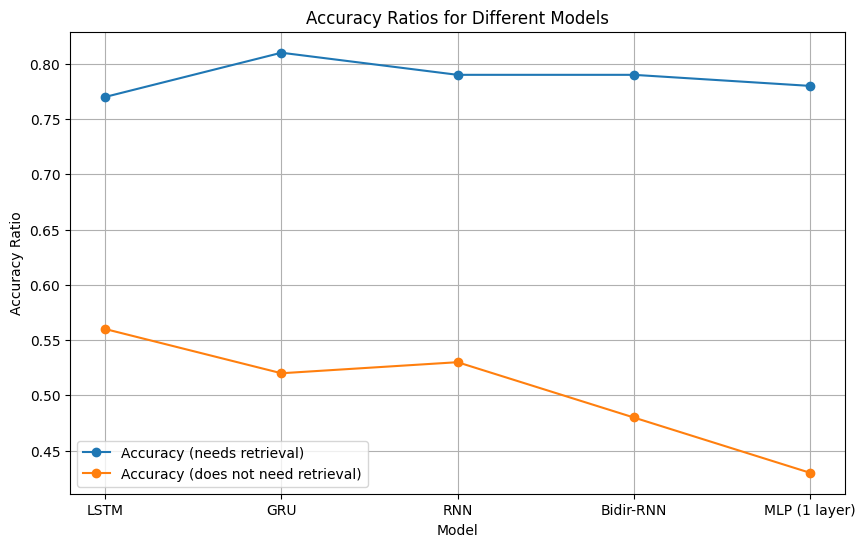

In [3]:
import matplotlib.pyplot as plt

# Data
models = ['LSTM', 'GRU', 'RNN', 'Bidir-RNN', 'MLP (1 layer)']
accuracy_needs_retrieval = [0.77, 0.81, 0.79, 0.79, 0.78]
accuracy_does_not_need_retrieval = [0.56, 0.52, 0.53, 0.48, 0.43]

# Plotting
x = range(len(models))

plt.figure(figsize=(10, 6))
plt.plot(x, accuracy_needs_retrieval, marker='o', label='Accuracy (needs retrieval)')
plt.plot(x, accuracy_does_not_need_retrieval, marker='o', label='Accuracy (does not need retrieval)')
plt.xticks(x, models)
plt.xlabel('Model')
plt.ylabel('Accuracy Ratio')
plt.title('Accuracy Ratios for Different Models')
plt.legend()
plt.grid(True)
plt.show()

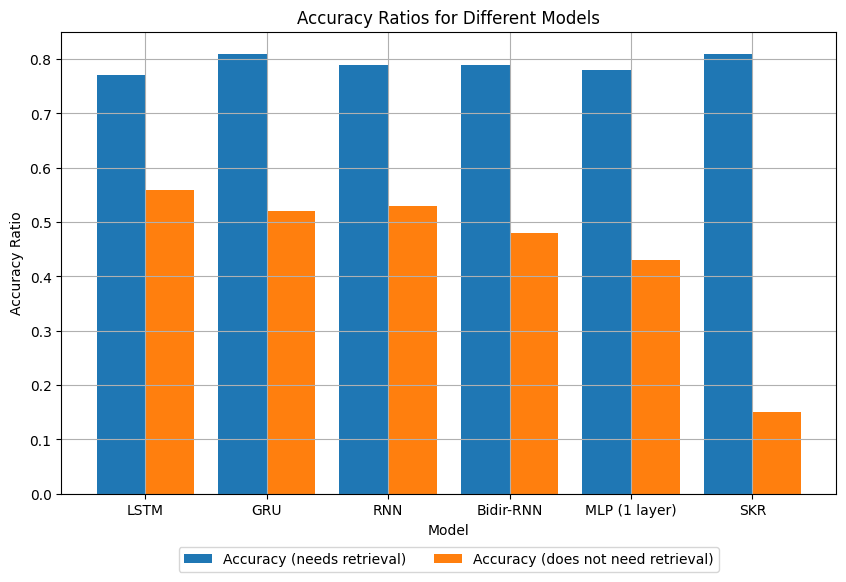

In [19]:
import matplotlib.pyplot as plt

# Data
models = ['LSTM', 'GRU', 'RNN', 'Bidir-RNN', 'MLP (1 layer)', 'SKR']
accuracy_needs_retrieval = [0.77, 0.81, 0.79, 0.79, 0.78, 0.81]
accuracy_does_not_need_retrieval = [0.56, 0.52, 0.53, 0.48, 0.43, 0.15]

# Plotting
x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, accuracy_needs_retrieval, width=0.4, label='Accuracy (needs retrieval)', align='center')
plt.bar([p + 0.4 for p in x], accuracy_does_not_need_retrieval, width=0.4, label='Accuracy (does not need retrieval)', align='center')

plt.xticks([p + 0.2 for p in x], models)
plt.xlabel('Model')
plt.ylabel('Accuracy Ratio')
plt.title('Accuracy Ratios for Different Models')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.grid(True)
plt.show()

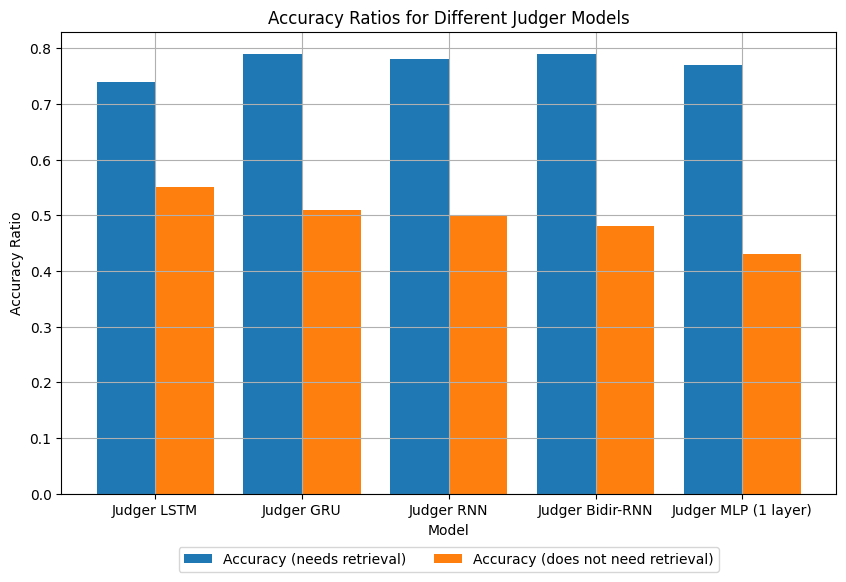

In [34]:
import matplotlib.pyplot as plt

# Data
models = ['Judger LSTM', 'Judger GRU', 'Judger RNN', 'Judger Bidir-RNN', 'Judger MLP (1 layer)']
accuracy_needs_retrieval = [0.74, 0.79, 0.78, 0.79, 0.77]
accuracy_does_not_need_retrieval = [0.55, 0.51, 0.50, 0.48, 0.43]

# Plotting
x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, accuracy_needs_retrieval, width=0.4, label='Accuracy (needs retrieval)', align='center')
plt.bar([p + 0.4 for p in x], accuracy_does_not_need_retrieval, width=0.4, label='Accuracy (does not need retrieval)', align='center')

plt.xticks([p + 0.2 for p in x], models)
plt.xlabel('Model')
plt.ylabel('Accuracy Ratio')
plt.title('Accuracy Ratios for Different Judger Models')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Move legend down
plt.grid(True)
plt.show()


##  Results - Pipelines Performance evaluation

### Length 200

Judger LSTM:

0.435

Judger GRU:

0.435

Judger MLP (1 layer):

0.425

No RAG:

0.285

Always RAG:

0.410

Judger RNN:

0.435

Judger Bidirectional RNN:

0.405